In [1]:
from models.experimental import attempt_load
import torch
import subprocess

from pathlib import Path
from utils.general import non_max_suppression, check_img_size, scale_coords, coco80_to_coco91_class
import cv2
from utils.datasets import letterbox
import numpy as np

from yolo_scripted import YoloFacade
import numpy
import torch

import json
import mean_average_precision
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

In [2]:
device = torch.device('cuda')

In [3]:
weights_path = 'runs/train/exp28/weights/best.pt'

In [3]:
!python test.py --weights runs/train/exp28/weights/best.pt --task test --data /home/nikita/YOLOv3/evonets_yolo/evo_dataset/evo_dataset.yaml

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='/home/nikita/YOLOv3/evonets_yolo/evo_dataset/evo_dataset.yaml', device='', exist_ok=False, img_size=640, iou_thres=0.6, name='exp', project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='test', verbose=False, weights=['runs/train/exp28/weights/best.pt'])
YOLOv5 🚀 v4.0-139-g1654a62 torch 1.7.1 CUDA:0 (GeForce RTX 2070 SUPER, 7979.1875MB)

Fusing layers... 
Model Summary: 476 layers, 87292900 parameters, 0 gradients, 217.4 GFLOPS
Scanning images:   0%|                                 | 0/1086 [00:00<?, ?it/s]test: WARNING: Ignoring corrupted image and/or label /home/nikita/YOLOv3/evonets_yolo/evo_dataset/images/test/4T3dDO4Rmrk_045300.jpg: duplicate labels
test: Scanning '/home/nikita/YOLOv3/evonets_yolo/evo_dataset/labels/test' images
test: New cache created: /home/nikita/YOLOv3/evonets_yolo/evo_dataset/labels/test.cache
               Class      Images      Labels 

In [6]:
model = attempt_load(weights_path, device)

Fusing layers... 


In [391]:
def detect_single(source: Path, model, device: torch.device, imgsz: int = 640):
        image = source.absolute().as_posix()

        max_stride = model.stride.max()
        imgsz = check_img_size(imgsz, s=max_stride)  # check img_size

        # Run inference
        im0 = cv2.imread(image, 1)
        img = letterbox(im0, new_shape=imgsz)[0]
        img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
        img = np.ascontiguousarray(img)

        img = torch.from_numpy(img).to(device)
        img = img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        with torch.no_grad():
            pred = model(img)

        # Process detections
        det = pred[0]
        if len(det) > 0:
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape)

        return det

### small objects

In [6]:
dataset_path = Path('/home/nikita/evonets/data/cones_dataset')

In [67]:
count = 0
whole = 0
for image in (dataset_path / 'images').glob('*'):
    an_filename = dataset_path / f'annotations/{image.stem}.json'
    
    h = 2.81
    w = 3
    
    with open(an_filename) as f:
        objects = json.load(f)['objects']
        
    for bbox in objects:
        if 'bbox' not in bbox:
            continue
        
        whole += 1
            
        x = bbox['bbox'][0]
        y = bbox['bbox'][1]
        old_w = bbox['bbox'][2]
        old_h = bbox['bbox'][3]
        new_w = old_w / w
        new_h = old_h / h
        
        if new_w < 3 or new_h < 3:
            count += 1
            """
            im0 = cv2.imread(image.as_posix(), 1)
            im1 = letterbox(im0, new_shape=640)[0]
            plt.figure(figsize=(20,10))
            
            plt.subplot(2,2,1)
            plt.imshow(im0)
            ax = plt.gca()
            rect = Rectangle((x,y),old_w,old_h,linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
            
            plt.subplot(2,2,2)
            plt.imshow(im1)
            ax = plt.gca()
            rect = Rectangle((x/w,y/h),new_w,new_h,linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
            
            plt.subplot(2, 2, 3)
            sign0 = im0[int(y-old_h):int(y+2*old_h), int(x-old_w):int(x+2*old_w),:]
            plt.imshow(sign0)
            ax = plt.gca()
            rect = Rectangle((old_w,old_h),old_w,old_h,linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
            
            plt.subplot(2, 2, 4)
            sign1 = im1[int(y/h-new_h-2):int(y/h+2*new_h-2), int(x/w-new_w):int(x/w+2*new_w),:]
            plt.imshow(sign1)
            ax = plt.gca()
            rect = Rectangle((new_w,new_h),new_w,new_h,linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
            
            plt.savefig(image.stem + 'comp.png')

            break
            """
            
print(count, whole)

1972 76630


### scripting

In [8]:
# !python models/export.py --weights runs/train/exp41/weights/best.pt --device cuda

In [107]:
def script_weights(weights_path, device):    
    traced_path = weights_path.parents[0] / (weights_path.stem + '.torchscript.pt')
    scripted_path = weights_path.parents[0] / ('scripted_' + weights_path.stem + '.torchscript.pt')
    
    YoloFacade.script(
        yolo_path=weights_path,
        traced_path=traced_path,
        scripted_path=scripted_path,
        device=device,
        conf_thres=0.1,
        iou_thres=0.6
    )
    print(f'scripted model at {scripted_path}')

In [7]:
script_weights(Path('/home/nikita/YOLOv5/runs/train/exp47/weights/best.pt'), device)

scripted model at /home/nikita/YOLOv5/runs/train/exp47/weights/scripted_best.torchscript.pt


### test

In [3]:
model = YoloFacade.load(Path('/home/nikita/5_47.pt'), device)

In [4]:
model.iou_thres = 0.6

In [5]:
model.conf_thres = 0.1

In [6]:
model.names

['none',
 'road',
 'automobile',
 'human',
 'main road',
 'give way',
 'stop sign',
 'brick sign',
 'traffic light',
 'red triangle',
 'red circle',
 'blue circle',
 'blue square',
 'sign',
 'other signs',
 'cone']

In [409]:
dataset_path = Path('/home/nikita/YOLOv3/evonets_yolo/evo_dataset')
an_test_dir = dataset_path / 'labels' / 'train'
im_test_dir = dataset_path / 'images' / 'train'

old_data_folder = Path('/home/nikita/evonets/data/youtube_alpha')
annotations_folder = old_data_folder / 'annotations'

In [410]:
with open((old_data_folder / 'params.json').as_posix()) as f:
    old_params = json.load(f)

In [411]:
new_classes = old_params['classes']

In [412]:
new_classes['конус'] = 15

In [413]:
new_classes

{'Главная дорога': 4,
 'Уступи дорогу': 5,
 'Стоп': 6,
 'Кирпич': 7,
 'Светофор': 8,
 'Красный треугольник': 9,
 'Красный круг': 10,
 'Синий круг': 11,
 'Синий квадрат': 12,
 'Табличка': 13,
 'Другие знаки': 14,
 'автомобиль': 2,
 'пешеход': 3,
 'road': 1,
 'конус': 15}

In [414]:
def objects_to_gt(objects):
    result = []
    
    for obj in objects:
        if 'bbox' not in obj:
            continue
          
        label = new_classes[obj['label']]
        bbox = obj['bbox']
        result.append(bbox + [label])
        
    return np.array(result)

In [415]:
import time

In [416]:
npArray = np.ndarray
from typing import (  # noqa: F401
    Any,
    Callable,
    Dict,
    Iterable,
    List,
    NamedTuple,
    Optional,
    Tuple,
    Union
)

npArray = np.ndarray

In [417]:
from mean_average_precision.adapter import AdapterBase

In [418]:
import numpy as np
from mean_average_precision import MetricBuilder
from mean_average_precision.adapter import AdapterBase


class EvoAdapter(AdapterBase):
    """Preprocessing and metrics calculating customization

    Handler of detection results that is used to reformat them to suit
    the mean_average_precision requirements.
    Performs the by-picture computations with ground-truth and predicted results,
    which are handled with '_gt_adapter' and '_preds_adapter'.
    The 'value' method returns the metric over accumulated data.
    """

    @classmethod
    def mapping_adapter(cls, mapping: Optional[Dict[int, int]] = None):
        return lambda metric_fn: cls(metric_fn, mapping=mapping)

    def __init__(
        self, metric_fn, value_config=None, mapping: Optional[Dict[int, int]] = None
    ):
        super().__init__(metric_fn, value_config)
        self.mapping = mapping or {}

    def _preds_adapter(self, preds: npArray) -> npArray:
        # swap columns to [..., label, confidence]
        preds = preds[:, [0, 1, 2, 3, 5, 4]]

        for detection in preds:
            detection[5] = self.mapping.get(detection[5], detection[5])

        return preds

    def _gt_adapter(self, gt: npArray) -> npArray:
        if not len(gt):
            return gt

        # add 'difficult' and 'crowd' labels
        padding = np.zeros((gt.shape[0], 2), dtype=int)
        gt = np.concatenate((gt, padding), axis=1)

        # tlwh -> tlbr
        gt[:, 2] += gt[:, 0]
        gt[:, 3] += gt[:, 1]

        return gt


def plenty_ap(
    predicted: List[npArray],
    groundtruth: List[npArray],
    n_classes: int,
    mapping: Optional[Dict[int, int]] = None,
) -> Dict[str, Any]:
    """Evaluates detection metric of COCO, PASCAL VOC and by-class AP

    Metrics overview: https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173

    Args:
        predicted: list of predictions per image - numpy arrays of shape `(detections_on_image, 6)`
            where 6 stands for `(x_left, y_top, x_right, y_bottom, confidence, label)`
        groundtruth: list of ground-truth objects - numpy arrays of shape `(detections_on_image, 5)`
            where 5 stands for `(x_left y_top x_right y_bottom label)`
            where 'label' is an integer class label from contiguous `[0, n_classes)`
        n_classes: total number of classes
        mapping: from predicted to ground truth.
            For example, ground truth has label `3` for person,
            predicted has label `2` for person. Then pass `mapping={2: 3}`

    Returns:
        dict: {
            "COCO-mAP": mAP@0.5:0.95:0.05,
            "PASCAL-mAP": mAP@0.5,
            "class-AP": {class label: AP@0.5}
        }
    """
    metric = MetricBuilder.build_evaluation_metric(
        "map_2d",
        async_mode=True,
        adapter_type=EvoAdapter.mapping_adapter(mapping),
        num_classes=n_classes,
    )

    for one_image_pred, one_image_gt in zip(predicted, groundtruth):
        metric.add(one_image_pred, one_image_gt)

    coco_metrics = metric.value(
        iou_thresholds=np.arange(0.5, 1.0, 0.05),
        recall_thresholds=np.arange(0.0, 1.01, 0.01),
        mpolicy='soft',
    )

    ap = {key: value['ap'] for key, value in coco_metrics[0.5].items()}

    coco_map = coco_metrics['mAP']

    pascal_map = metric.value(
        iou_thresholds=0.5, recall_thresholds=np.arange(0.0, 1.1, 0.1)
    )['mAP']

    return {'COCO-mAP': coco_map, 'PASCAL-mAP': pascal_map, 'class-AP': ap}

In [440]:
from torch.autograd.profiler import profile
from tqdm.notebook import tqdm, trange

In [445]:
def get_test_data(annotations_folder, an_test_dir, im_test_dir, model, imgsz=640):
    groundtruth = []
    predicted = []

    torch.cuda.synchronize()
    
    times = []

    for filename in an_test_dir.glob('*'): 
        filename = annotations_folder / (filename.stem + '.json')
        with open(filename) as f:
            data = json.load(f)

            objects = data['objects']

            groundtruth.append(objects_to_gt(objects))
            
        image = im_test_dir / (filename.stem + '.jpg')
        
        torch.cuda.synchronize()
        with profile(use_cuda=True, profile_memory=True) as prof:
            start_time = time.perf_counter()
            det = detect_single(image, model, device, imgsz=imgsz).cpu().numpy()
            end_time = time.perf_counter()

        predicted.append(np.array(det))
        times.append(end_time - start_time)
        
    print(f'average time, ms: {np.mean(times) * 1e3}; standart deviation: {np.std(times) * 1e3}')

    return predicted, groundtruth

In [446]:
predicted_youtube, groundtruth_youtube= get_test_data(annotations_folder,
                                                      an_test_dir,
                                                      im_test_dir,
                                                      model, 
                                                      imgsz=640)

average time, ms: 52.947114112419406; standart deviation: 1.2906910720578635


46 - 30 epochs youtube only, 47 - cones from 41, 5 epochs

In [274]:
plenty_ap(predicted_youtube, groundtruth_youtube, 16)

{'COCO-mAP': 0.23597379,
 'PASCAL-mAP': 0.39092156,
 'class-AP': {0: 0.0,
  1: 0.59272057,
  2: 0.79233676,
  3: 0.6379991,
  4: 0.29876238,
  5: 0.40336558,
  6: 0.6100881,
  7: 0.61888623,
  8: 0.5805146,
  9: 0.61804736,
  10: 0.50817657,
  11: 0.5693446,
  12: 0.0,
  13: 0.0,
  14: 0.0,
  15: 0.0}}

In [447]:
dataset_path = Path('/home/nikita/YOLOv3/evonets_yolo/cones_dataset')
an_test_dir = dataset_path / 'labels' / 'train'
im_test_dir = dataset_path / 'images' / 'train'

old_data_folder = Path('/home/nikita/evonets/data/pec_cones')
annotations_folder = old_data_folder / 'annotations'

In [448]:
predicted_cones, groundtruth_cones = get_test_data(annotations_folder,
                                                   an_test_dir,
                                                   im_test_dir,
                                                   model, 
                                                   imgsz=640)

average time, ms: 43.5868213854202; standart deviation: 0.7130438671116955


In [449]:
full_pred = predicted_youtube + predicted_cones
full_gt = groundtruth_youtube + groundtruth_cones

In [278]:
plenty_ap(full_pred, full_gt, 16, {})

{'COCO-mAP': 0.25315252,
 'PASCAL-mAP': 0.41858947,
 'class-AP': {0: 0.0,
  1: 0.59272057,
  2: 0.79236704,
  3: 0.6518802,
  4: 0.29876238,
  5: 0.40309334,
  6: 0.6100881,
  7: 0.61888623,
  8: 0.580198,
  9: 0.61804736,
  10: 0.50817657,
  11: 0.5693446,
  12: 0.0,
  13: 0.0,
  14: 0.0,
  15: 0.43722287}}

### Size-precision statistics

In [450]:
from collections import defaultdict

In [451]:
def IoU(bbox1, bbox2):
    # x_left, y_top, width, height
    if bbox1[0] > bbox2[2] + bbox2[0] or bbox2[0] > bbox1[2] + bbox1[0]:
        return 0
    if bbox1[1] > bbox2[3] + bbox2[1] or bbox2[1] > bbox1[3] + bbox1[1]:
        return 0
    
    # intersection
    width = min(bbox1[2] + bbox1[0] - bbox2[0], bbox2[2] + bbox2[0] - bbox1[0])
    assert width > 0
    height = min(bbox1[3] + bbox1[1] - bbox2[1], bbox2[3] + bbox2[1] - bbox1[1])
    assert height > 0
    
    s1 = (bbox1[2]) * (bbox1[3])
    s2 = (bbox2[2]) * (bbox2[3])
    inter = width * height
    
    iou = inter / (s1 + s2 - inter)
    assert iou >= 0
    
    return iou

In [452]:
test_bbox_1 = [0, 0, 2, 2]
test_bbox_2 = [1, 1, 1, 1]
test_bbox_3 = [1, 1, 2, 2]

print(IoU(test_bbox_1, test_bbox_1))
print(IoU(test_bbox_1, test_bbox_2))
print(IoU(test_bbox_1, test_bbox_3))

1.0
0.25
0.14285714285714285


In [453]:
def class_to_size_to_percentage(predicted, gruondtruth, classes, iou_thres=0.6):
    width_table = defaultdict(lambda: defaultdict(list))
    height_table = defaultdict(lambda: defaultdict(list))
    area_table = defaultdict(lambda: defaultdict(list))
    overall_width_table = defaultdict(list)
    overall_height_table = defaultdict(list)
    overall_area_table = defaultdict(list)
    
    for image_pred, image_gt in zip(predicted, gruondtruth):
        image_pred = np.copy(image_pred)
        image_pred[:, 2] -= image_pred[:, 0]
        image_pred[:, 3] -= image_pred[:, 1]
        
        for bbox_gt in image_gt:
            class_name = classes[int(bbox_gt[4])]
            width = int(bbox_gt[2])
            height = int(bbox_gt[3])
            area = width * height
            
            detected = False
            for bbox_pr in image_pred:
                if bbox_pr[2] < 0 or bbox_pr[3] < 0:
                    continue
                    
                
                # print(bbox_pr, bbox_gt)                
                if bbox_pr[5] == bbox_gt[4] and IoU(bbox_pr, bbox_gt) >= iou_thres:
                    detected = True
                    break
                                       
            width_table[class_name][width].append(detected)
            height_table[class_name][height].append(detected)
            area_table[class_name][area].append(detected)
            overall_width_table[width].append(detected)
            overall_height_table[height].append(detected)
            overall_area_table[area].append(detected)
            
            
    return width_table, height_table, area_table, overall_width_table, overall_height_table, overall_area_table

In [454]:
classes = {value: key for key, value in new_classes.items()}

In [455]:
width_table, height_table, area_table, width_all_table, height_all_table, area_all_table = class_to_size_to_percentage(full_pred, full_gt, classes)

In [456]:
def cumulative(table):
    x = sorted(table.keys())
    tp = [np.array(table[x_]).sum() for x_ in x]
    p = [len(table[x_]) for x_ in x]
    
    y = []
    for x_ in range(len(x)):
        y.append(np.sum(tp[x_:]) / np.sum(p[x_:]))
        
    return x, y

In [464]:
def plot_bar(class_table, param, classname, lims=(0, 100), filename='default.jpg', cmltv=False):
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
    
    if cmltv:
        x, y = cumulative(class_table)
    else:
        x = sorted(class_table.keys())
        y = [np.array(class_table[index]).sum() / len(class_table[index]) for index in x]
    plt.figure(figsize=(20, 12))
    plt.xlabel(f'{param}, px')
    plt.ylabel('Cumulative recall on [x, max_size]' if cmltv else 'Recall')
    plt.title(classname)

    ml = MultipleLocator(1)
    plt.axes().xaxis.set_minor_locator(ml)

    plt.plot(x, y)
    plt.xlim(lims)
    plt.grid(which='minor')
    plt.grid(which='major')
    plt.savefig(filename)

<ipython-input-464-682c46e8b11b>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_minor_locator(ml)


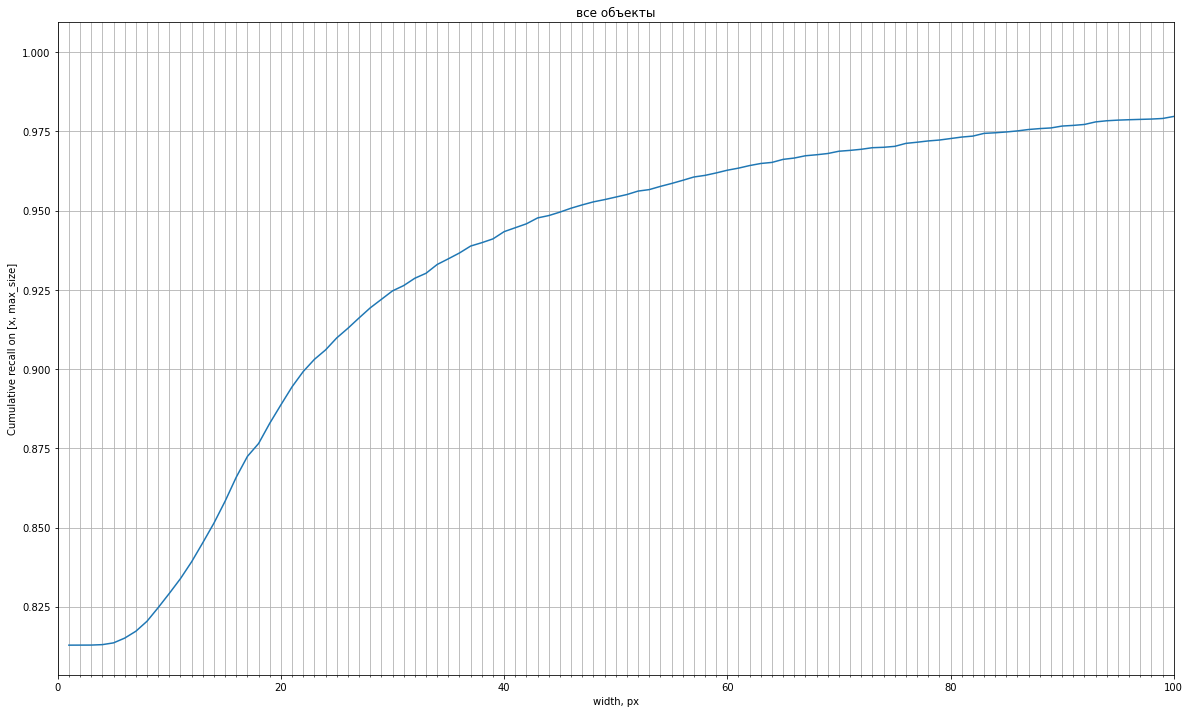

In [468]:
plot_bar(width_all_table, 'width', 'все объекты', filename='recall_analysis/all_width.jpg', cmltv=True)

<ipython-input-464-682c46e8b11b>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_minor_locator(ml)


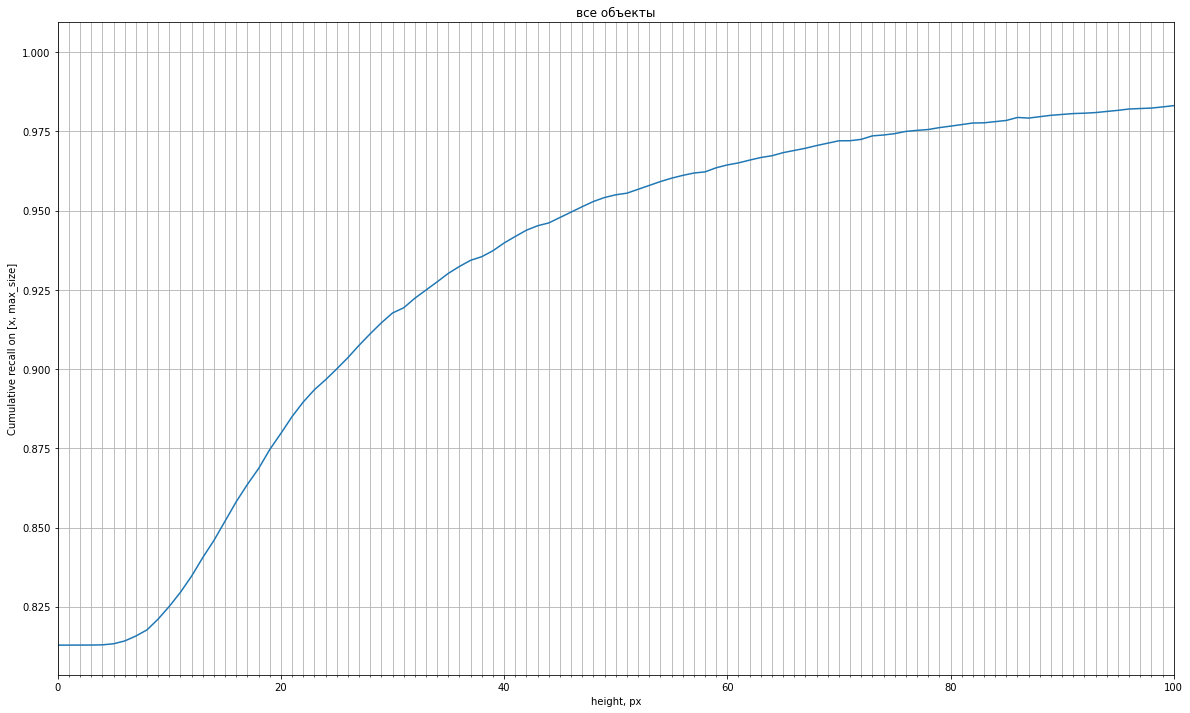

In [469]:
plot_bar(height_all_table, 'height', 'все объекты', filename='recall_analysis/all_height.jpg', cmltv=True)

<ipython-input-464-682c46e8b11b>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_minor_locator(ml)


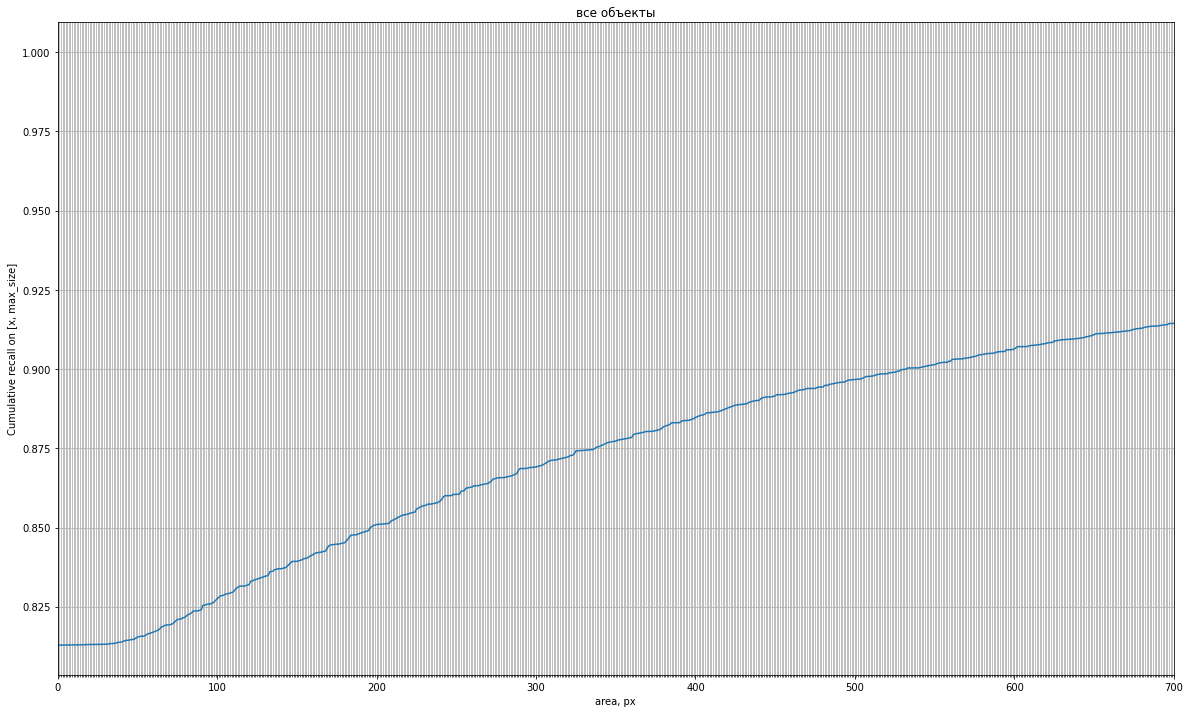

In [470]:
plot_bar(area_all_table, 'area', 'все объекты', lims=(0, 700), filename='recall_analysis/all_area.jpg', cmltv=True)

<ipython-input-464-682c46e8b11b>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_minor_locator(ml)


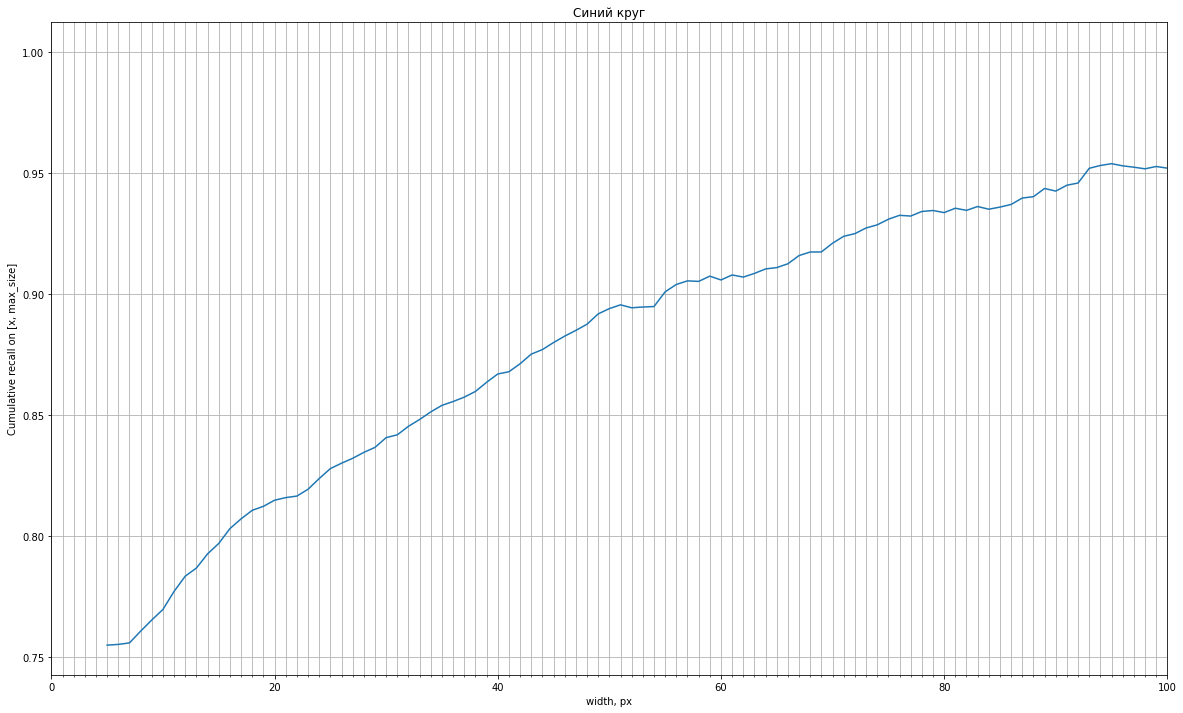

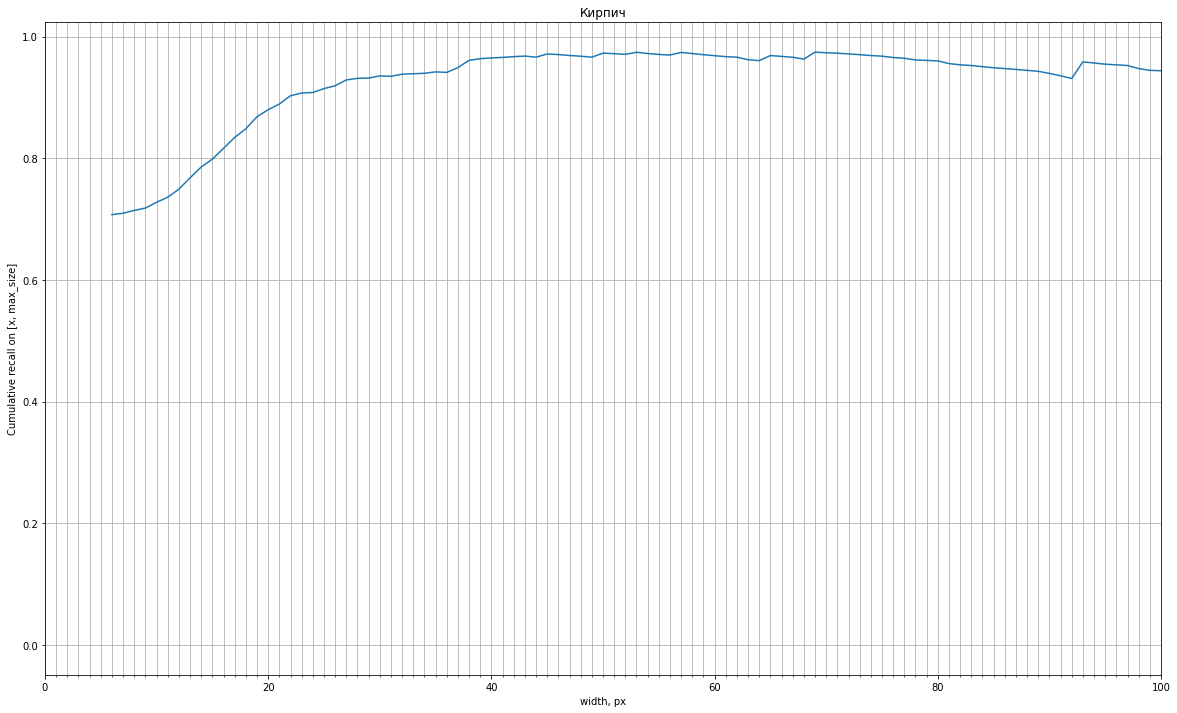

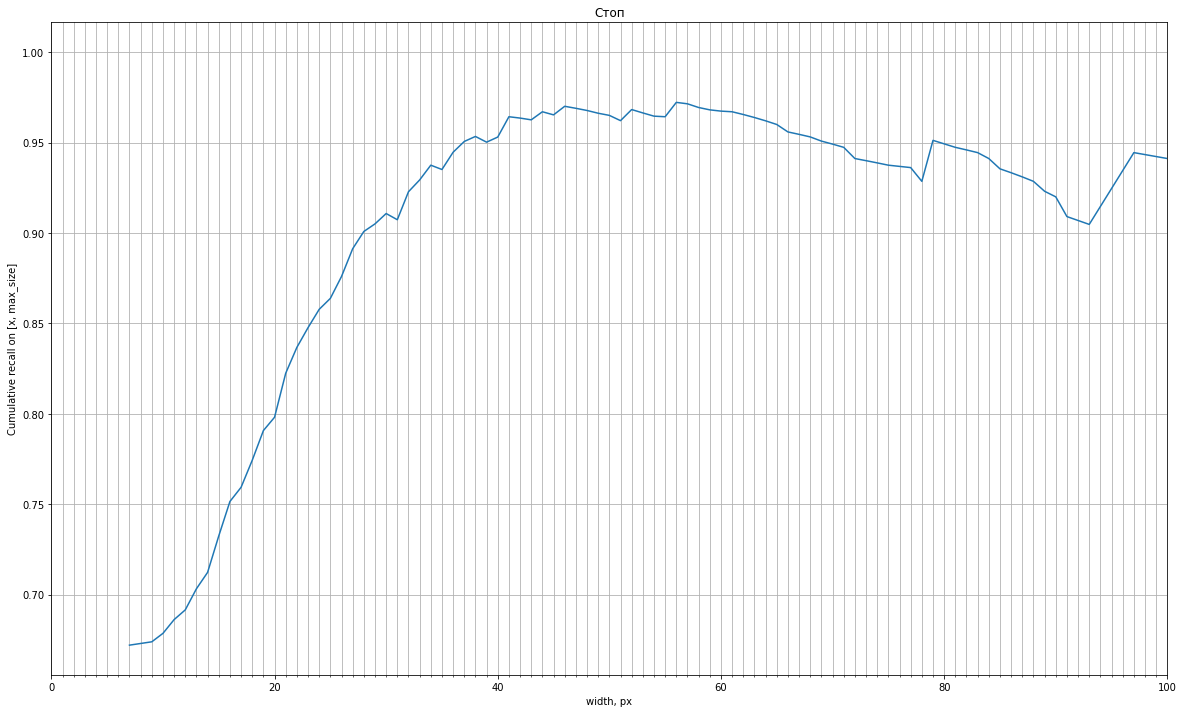

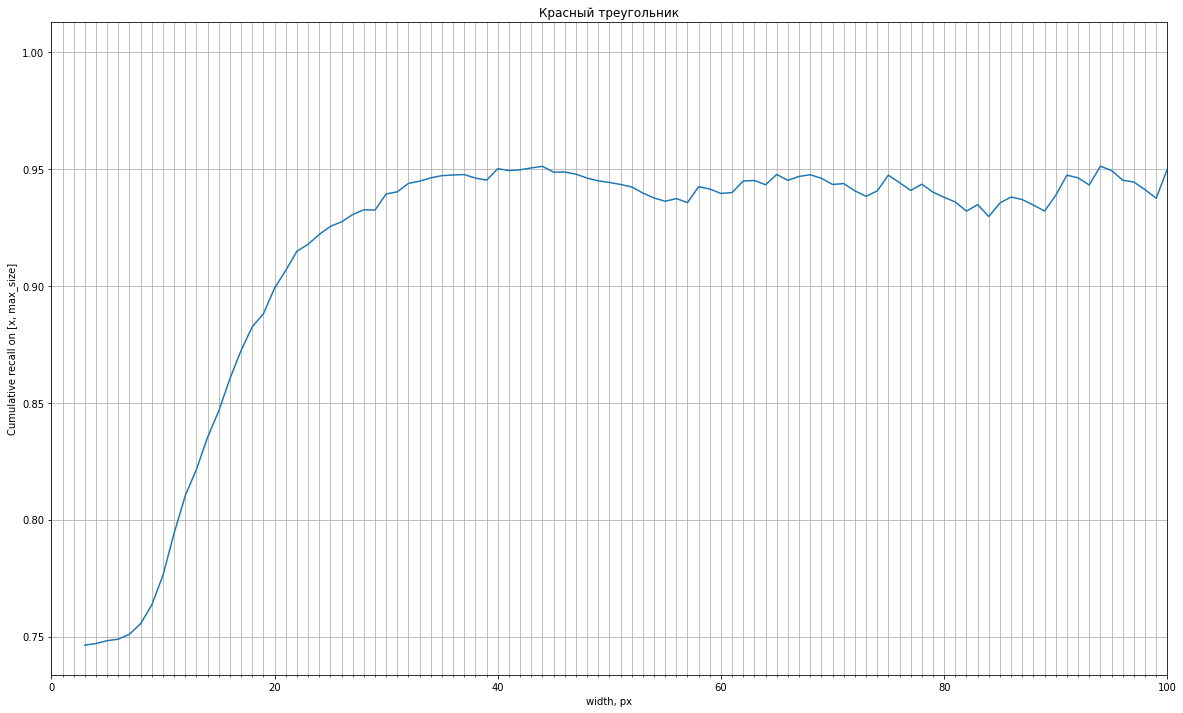

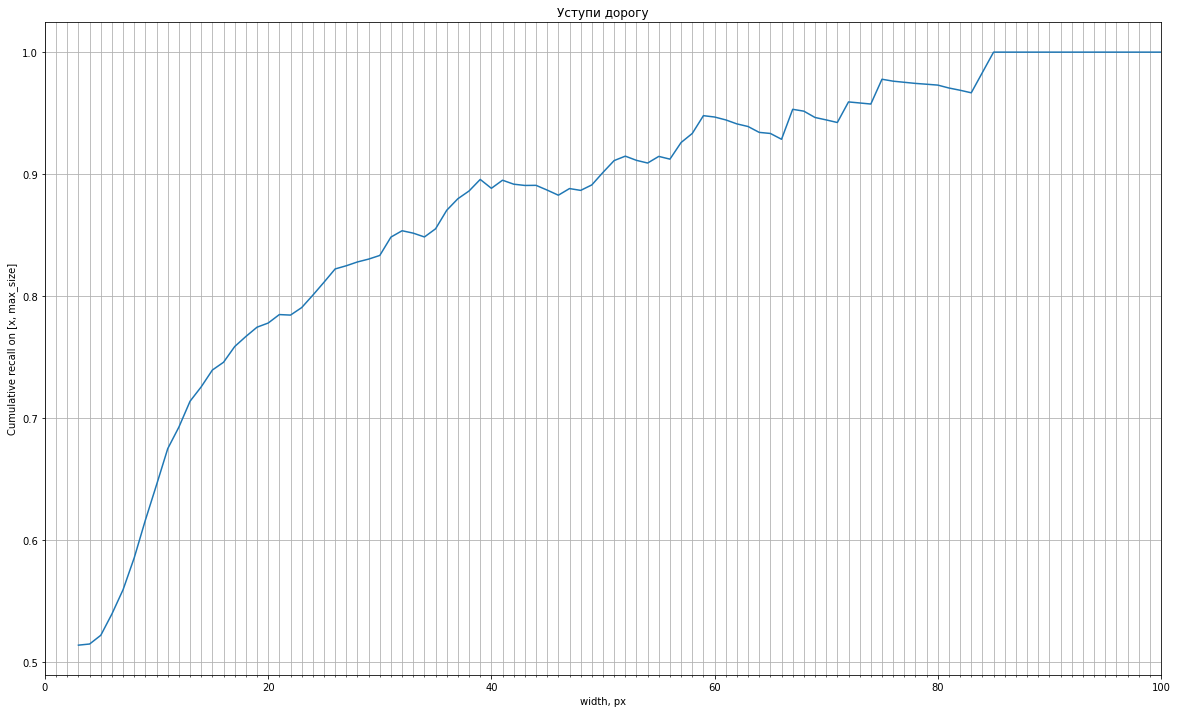

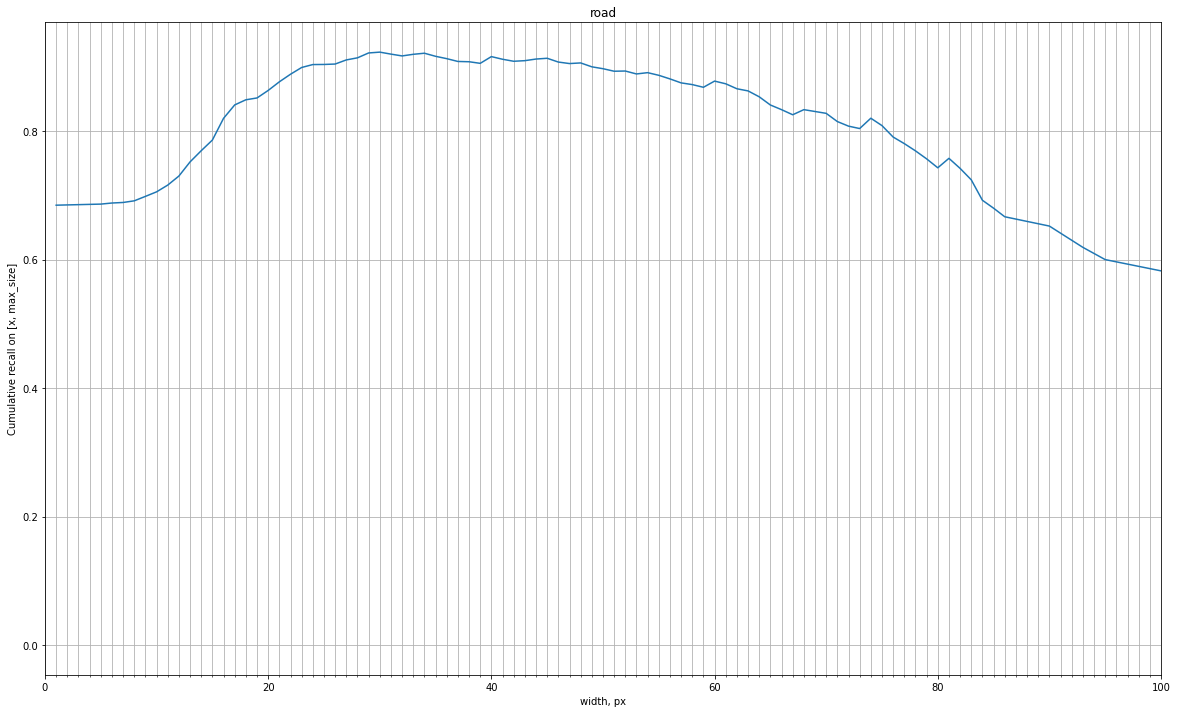

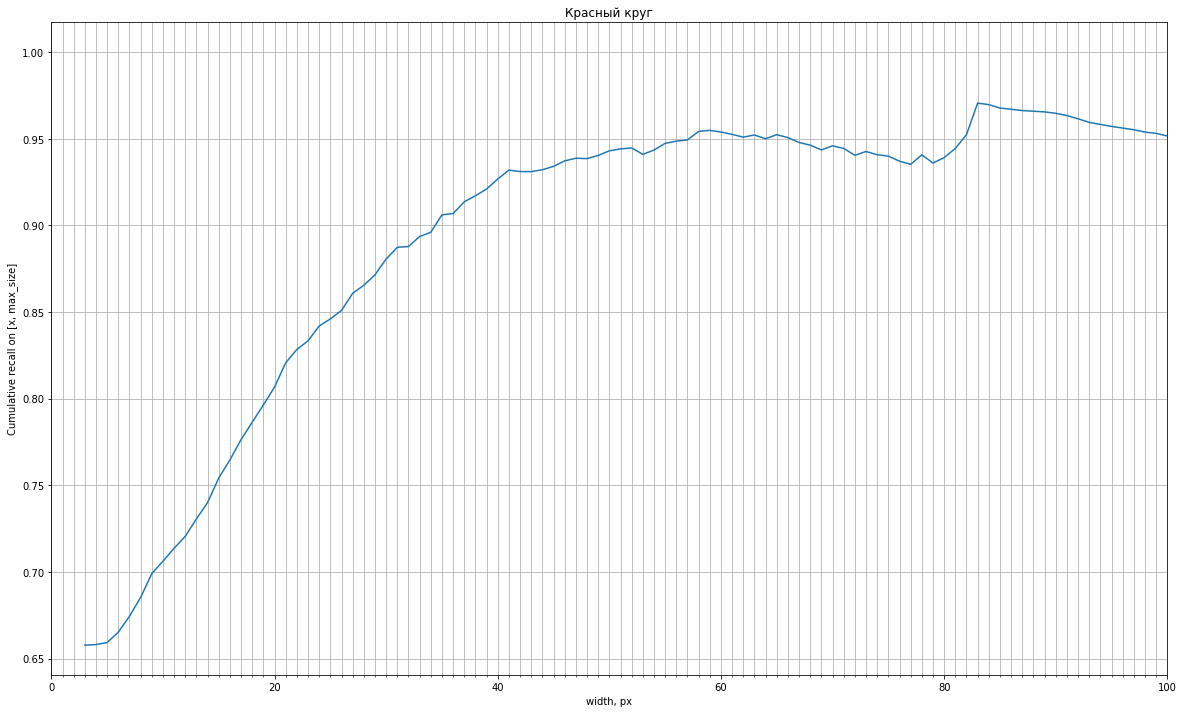

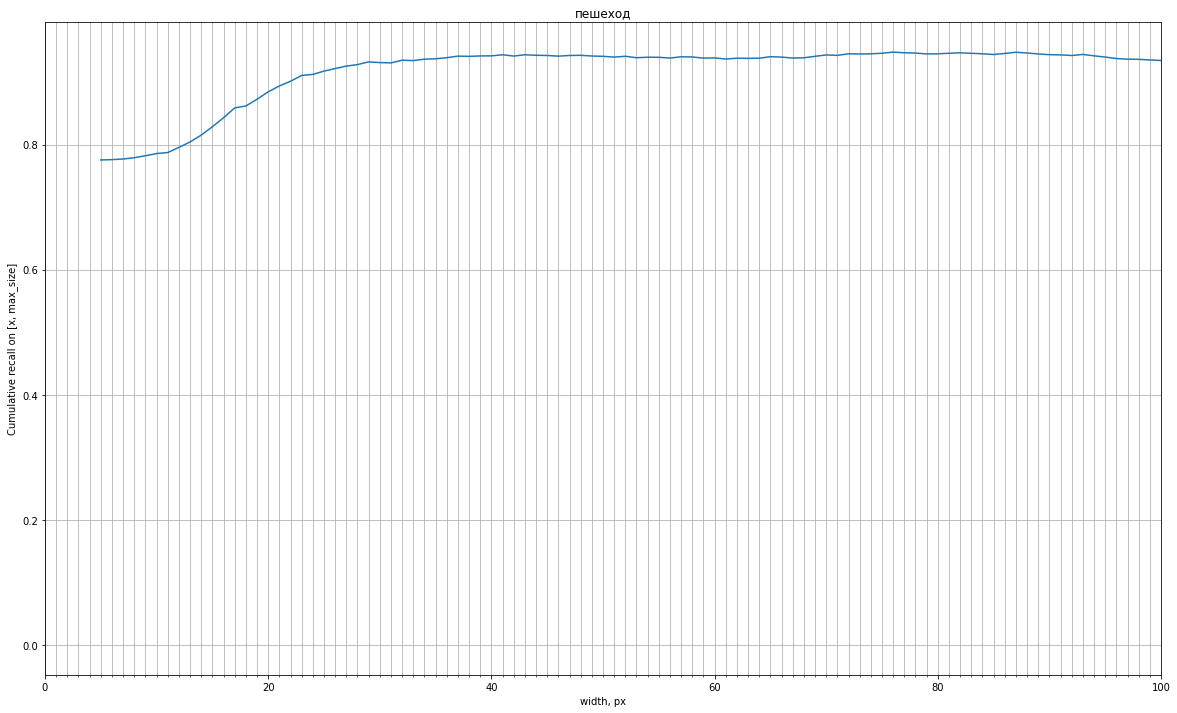

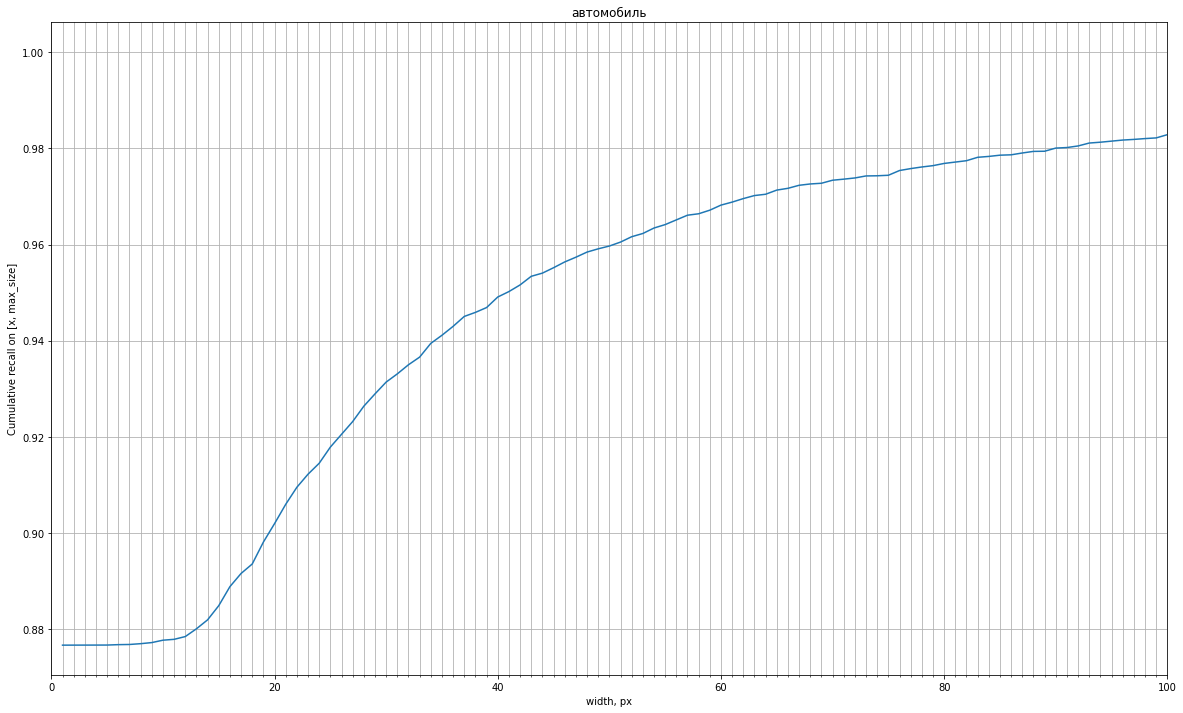

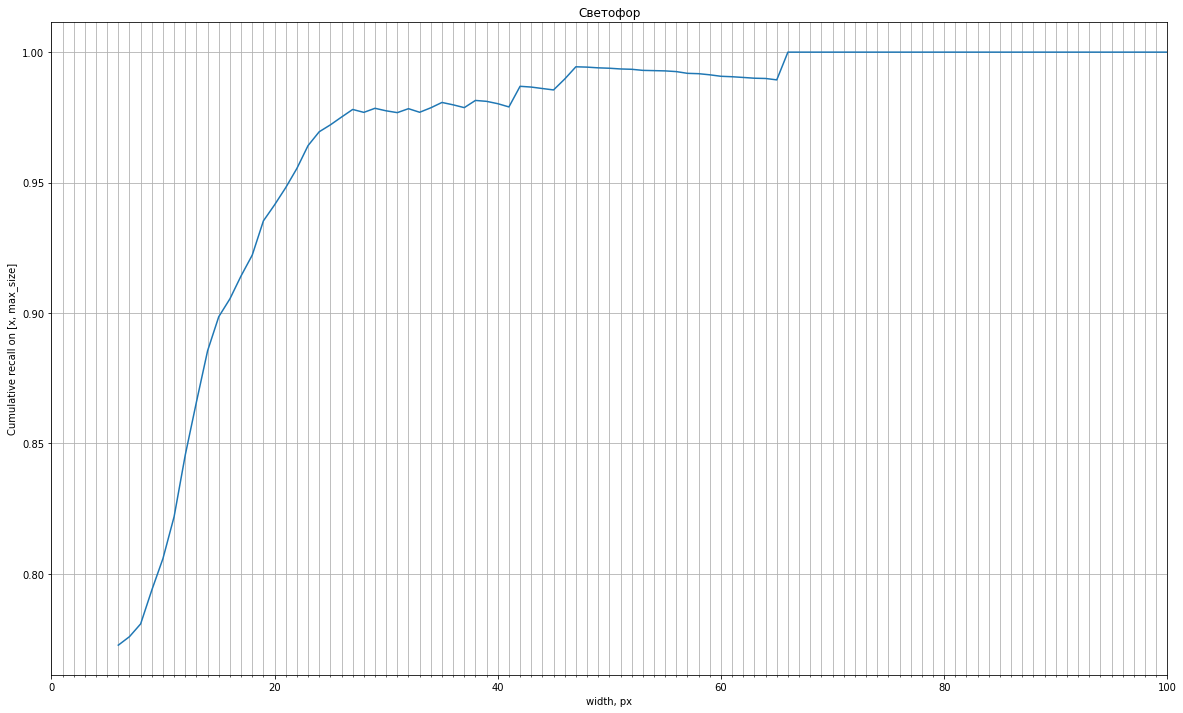

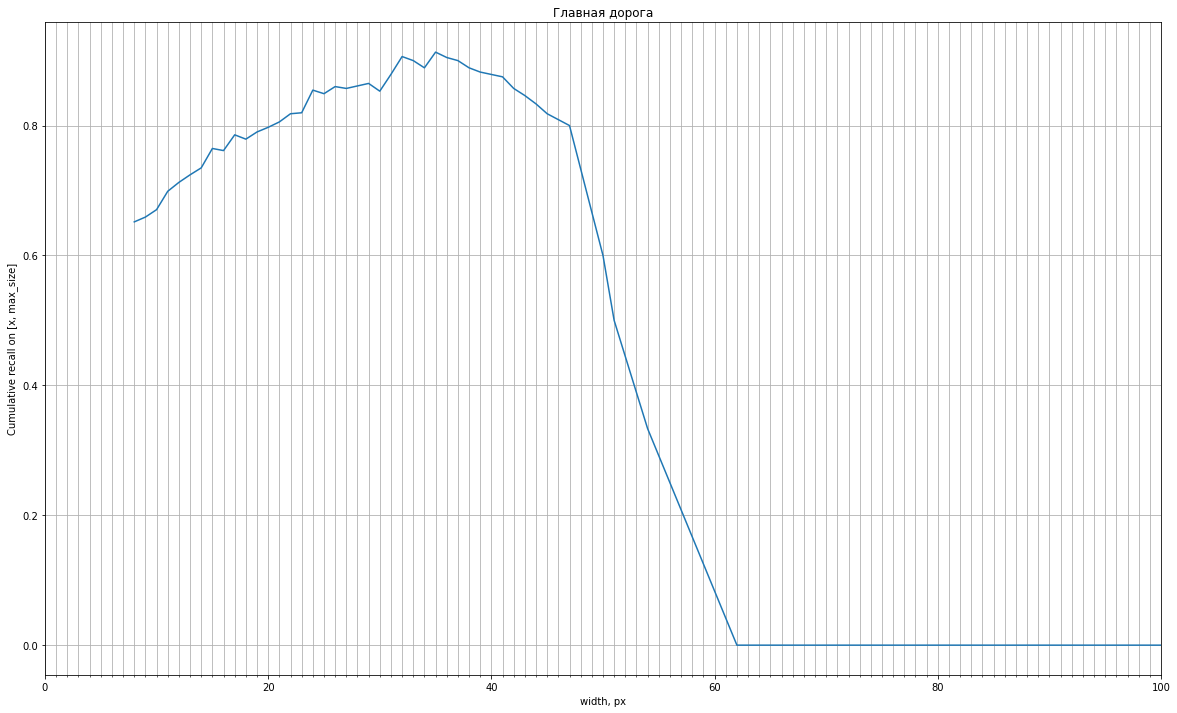

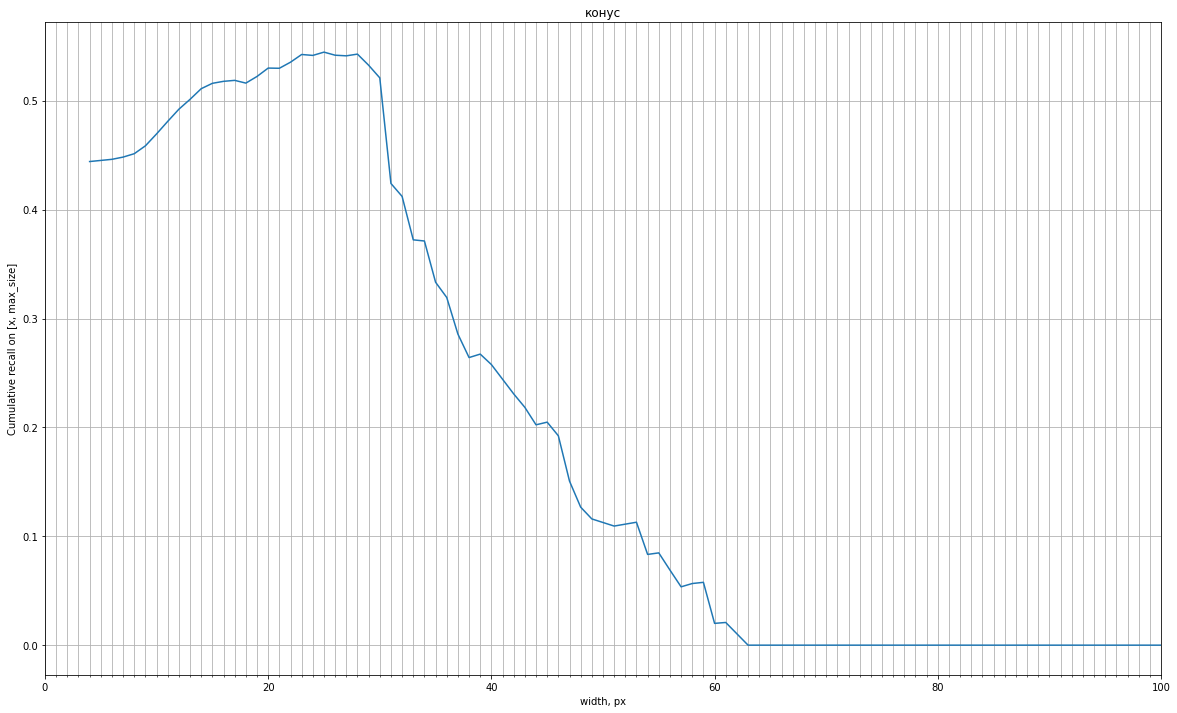

In [471]:
for class_name, class_table in width_table.items():
    plot_bar(class_table, 'width', class_name, lims=(0, 100), filename=f'recall_analysis/{class_name}_width.jpg', cmltv=True)

<ipython-input-464-682c46e8b11b>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_minor_locator(ml)


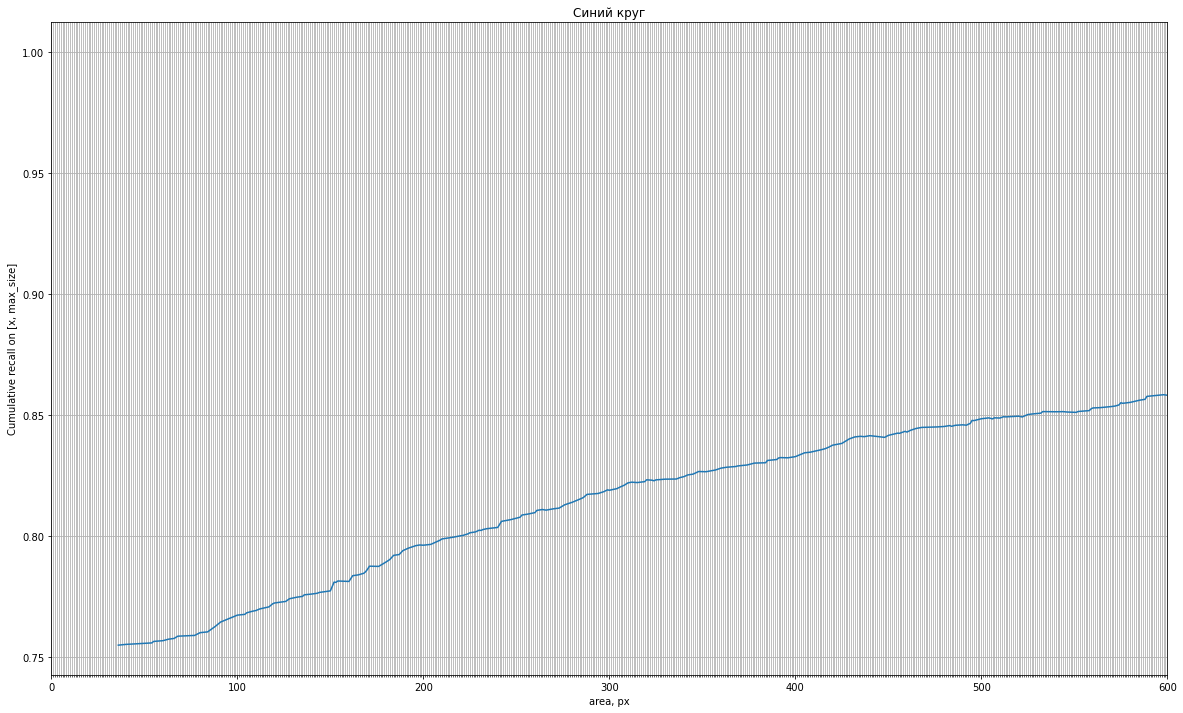

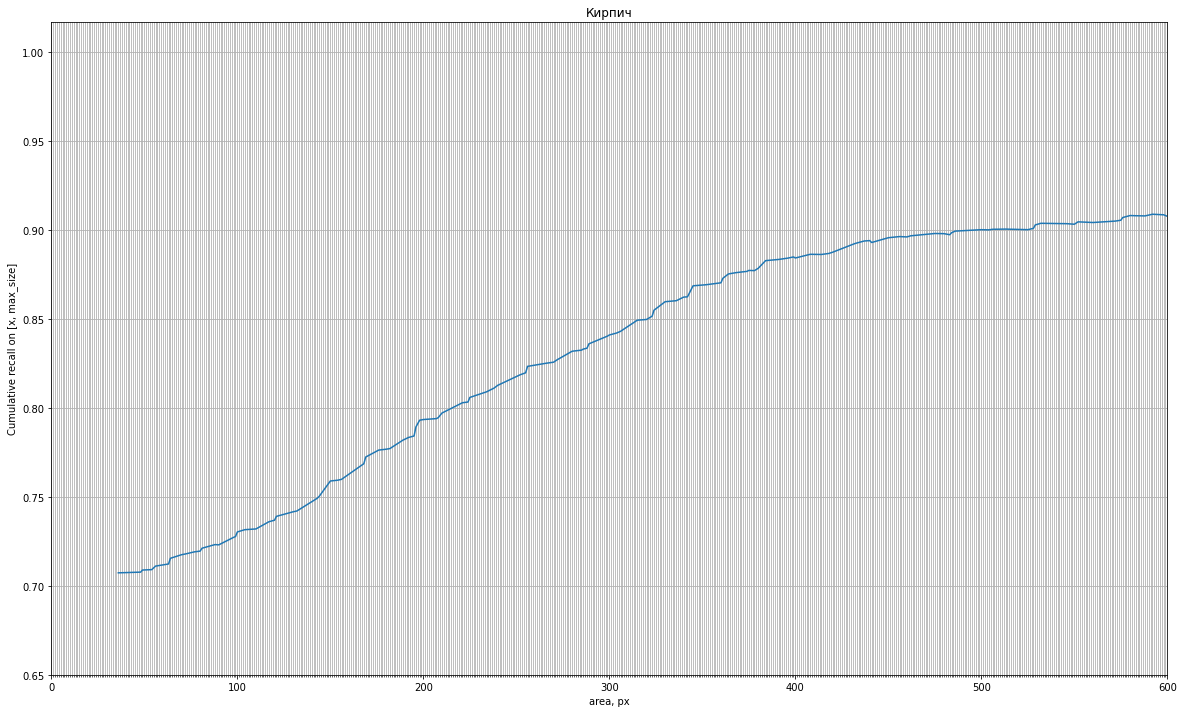

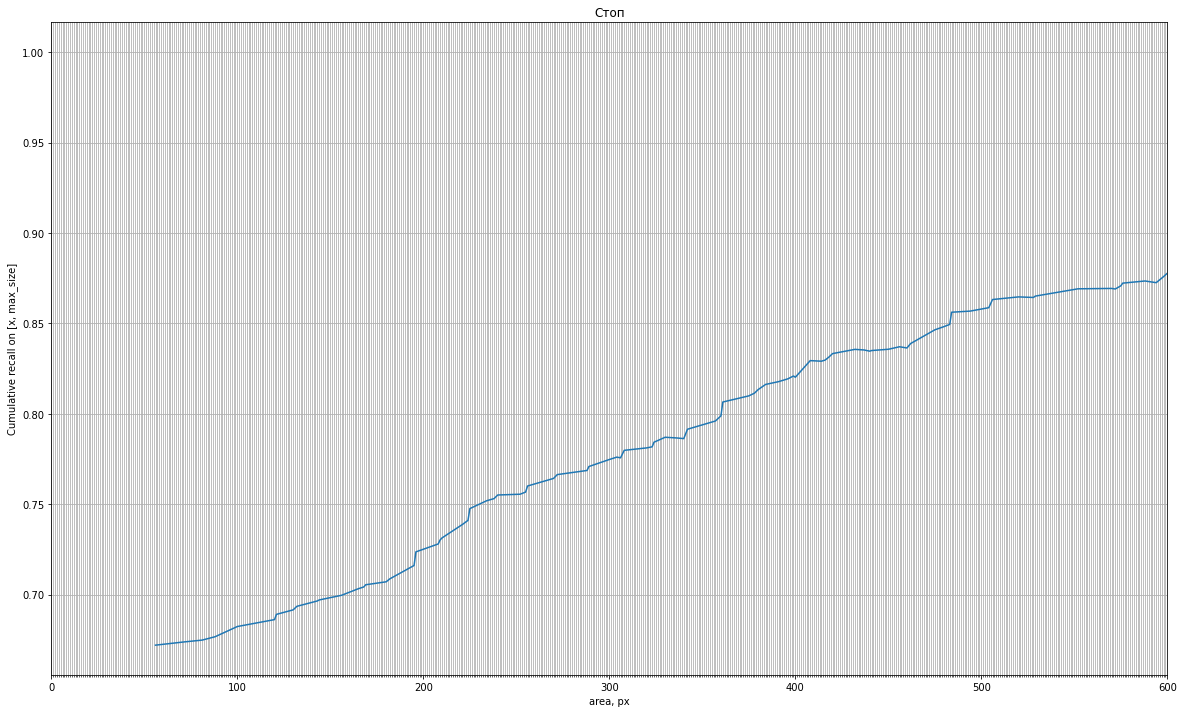

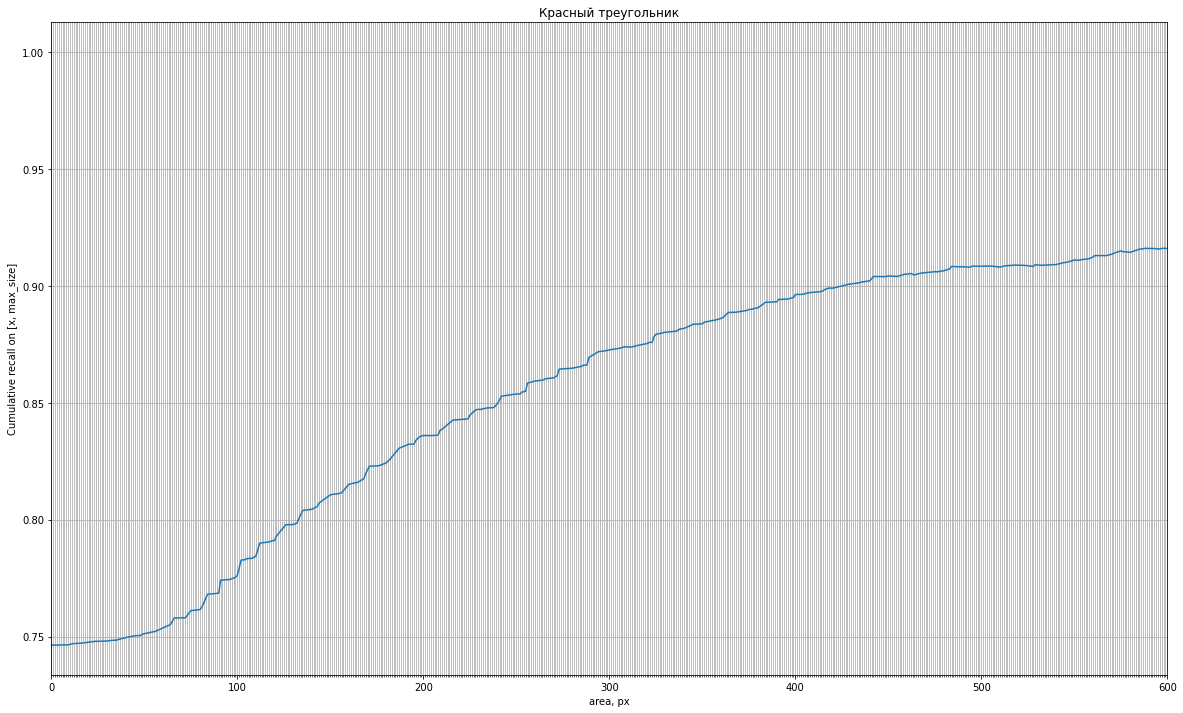

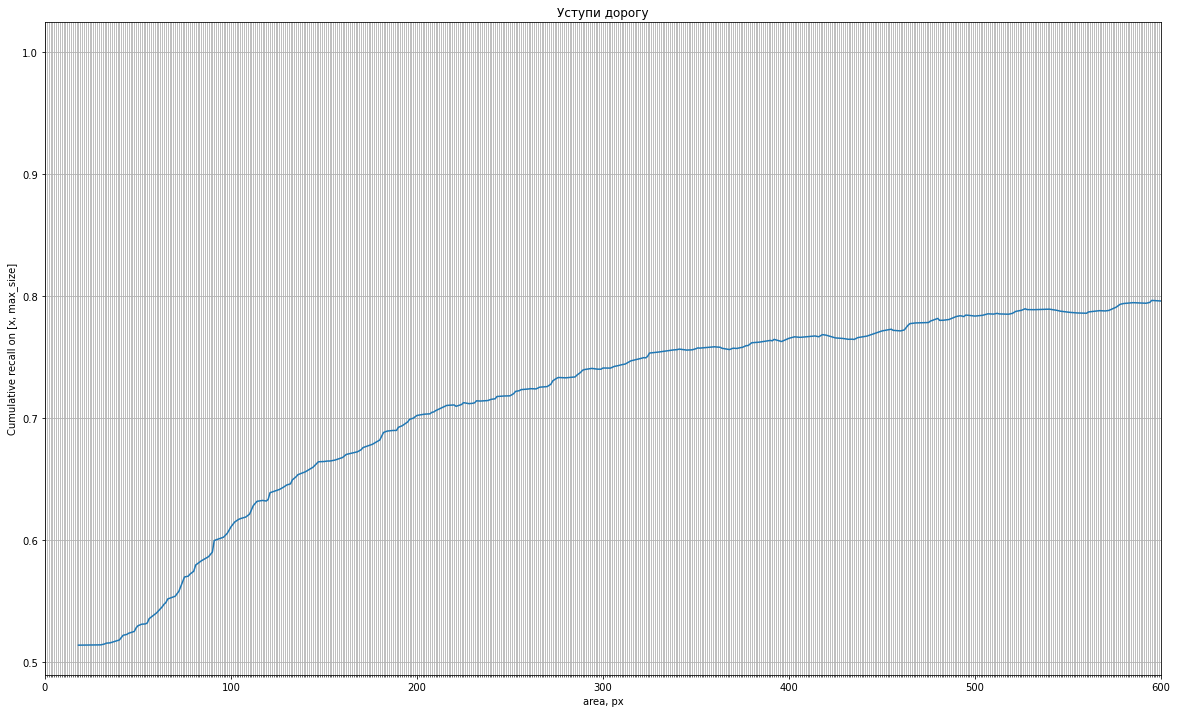

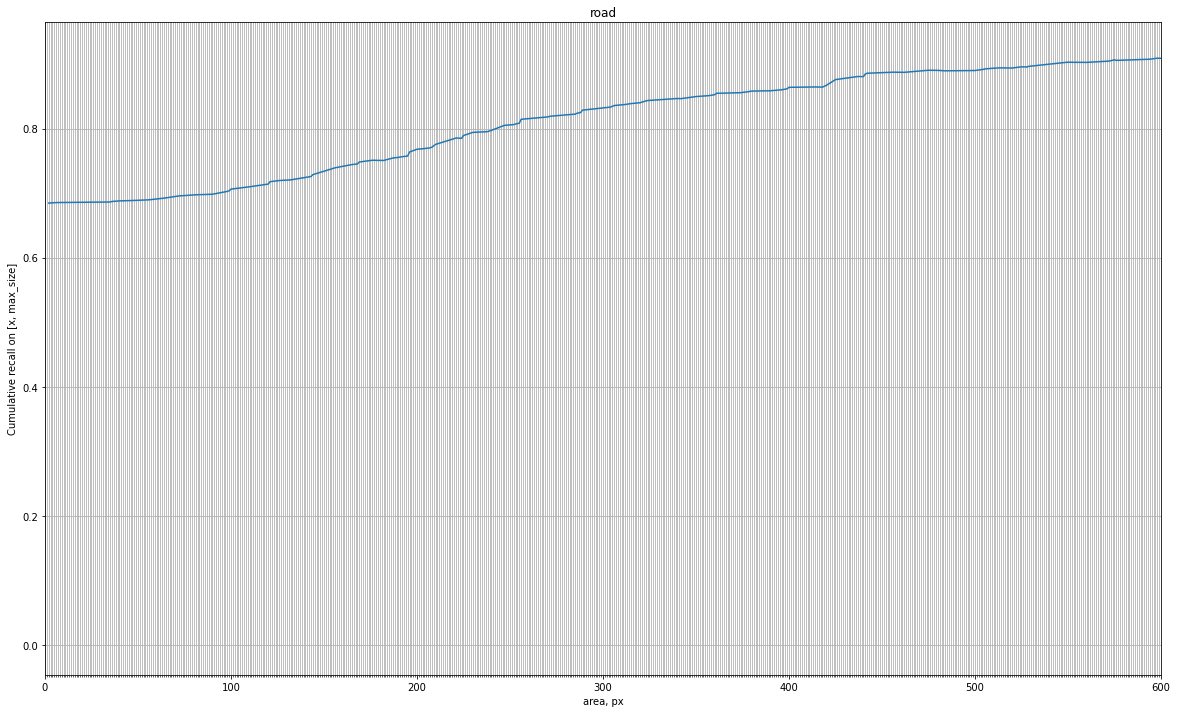

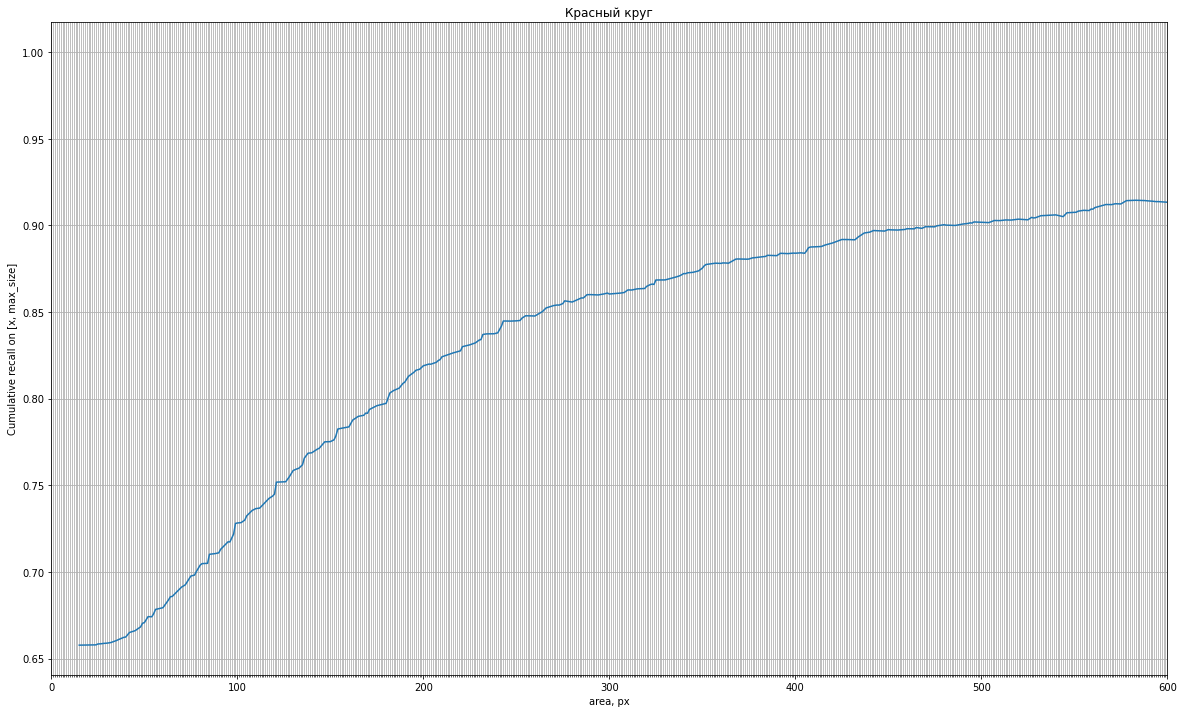

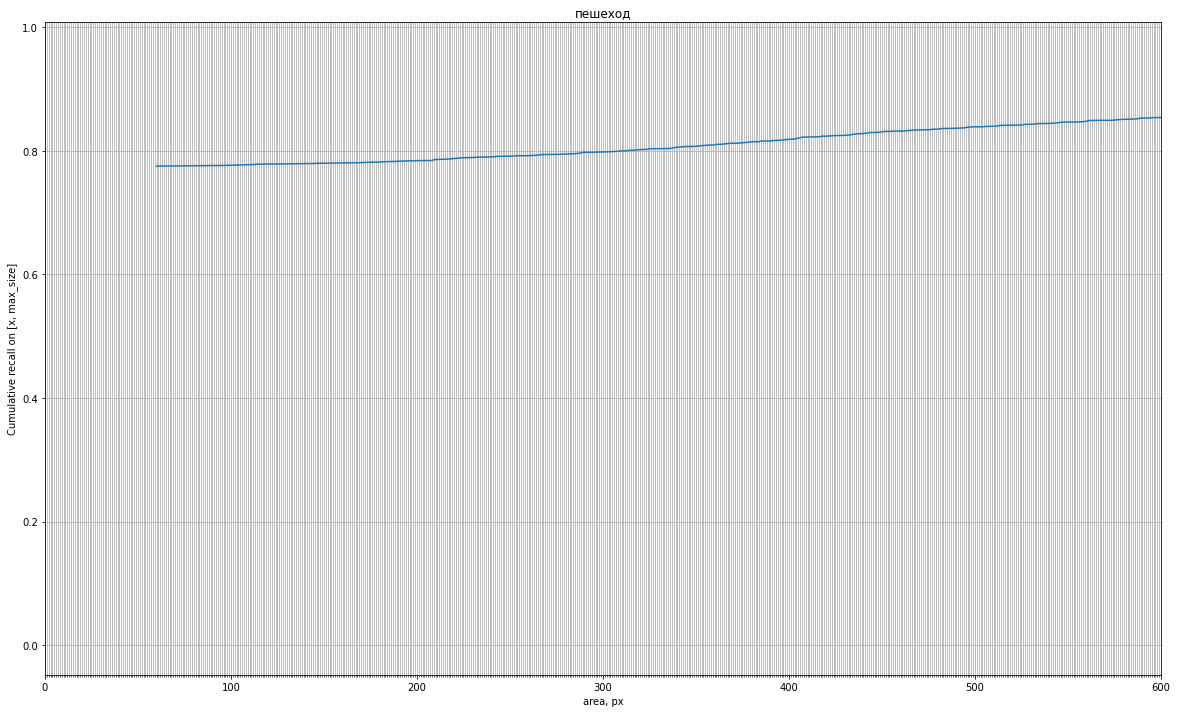

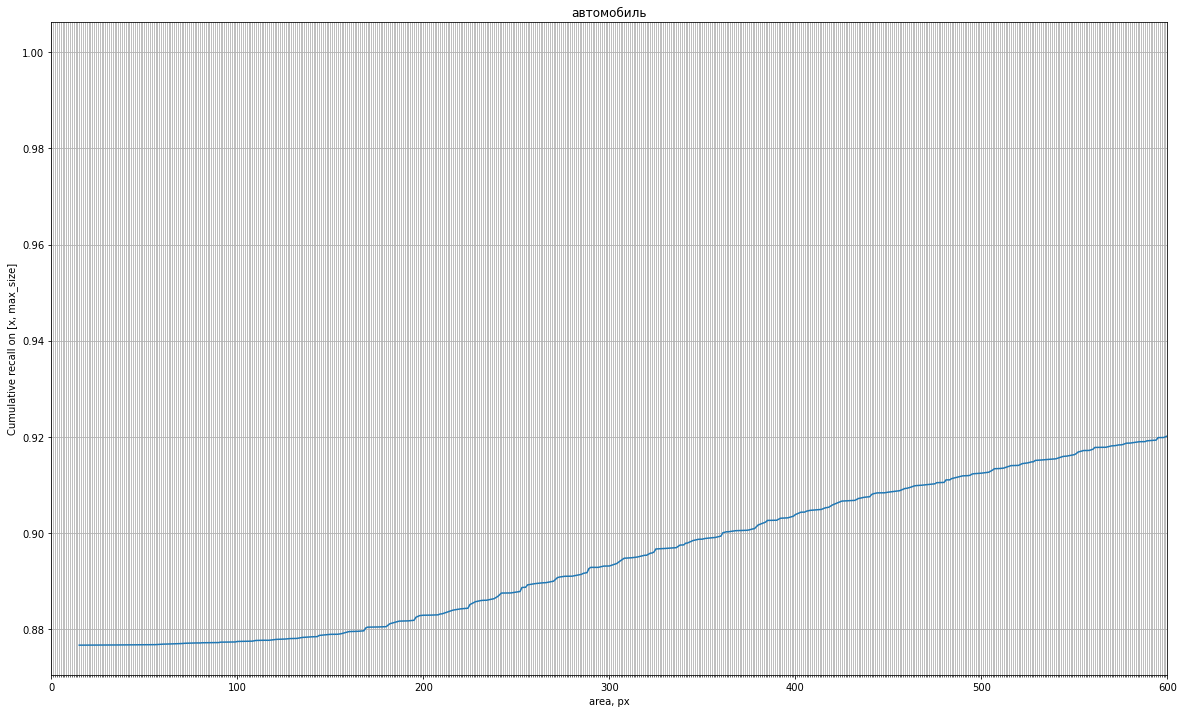

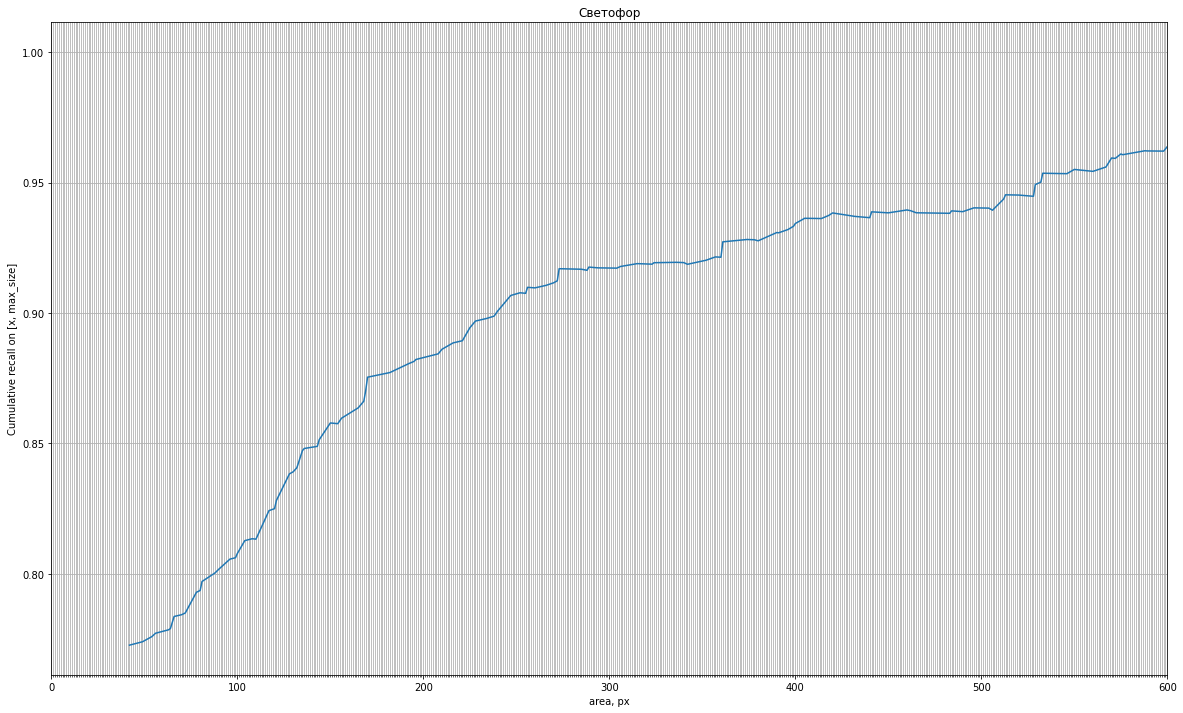

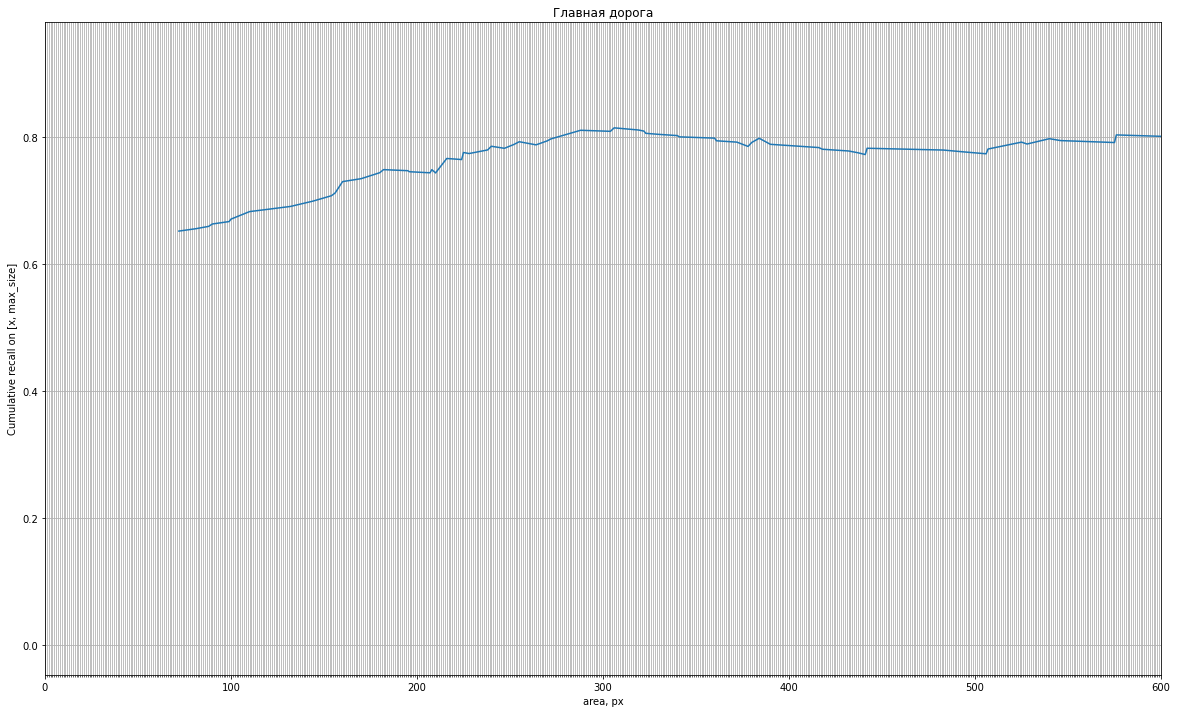

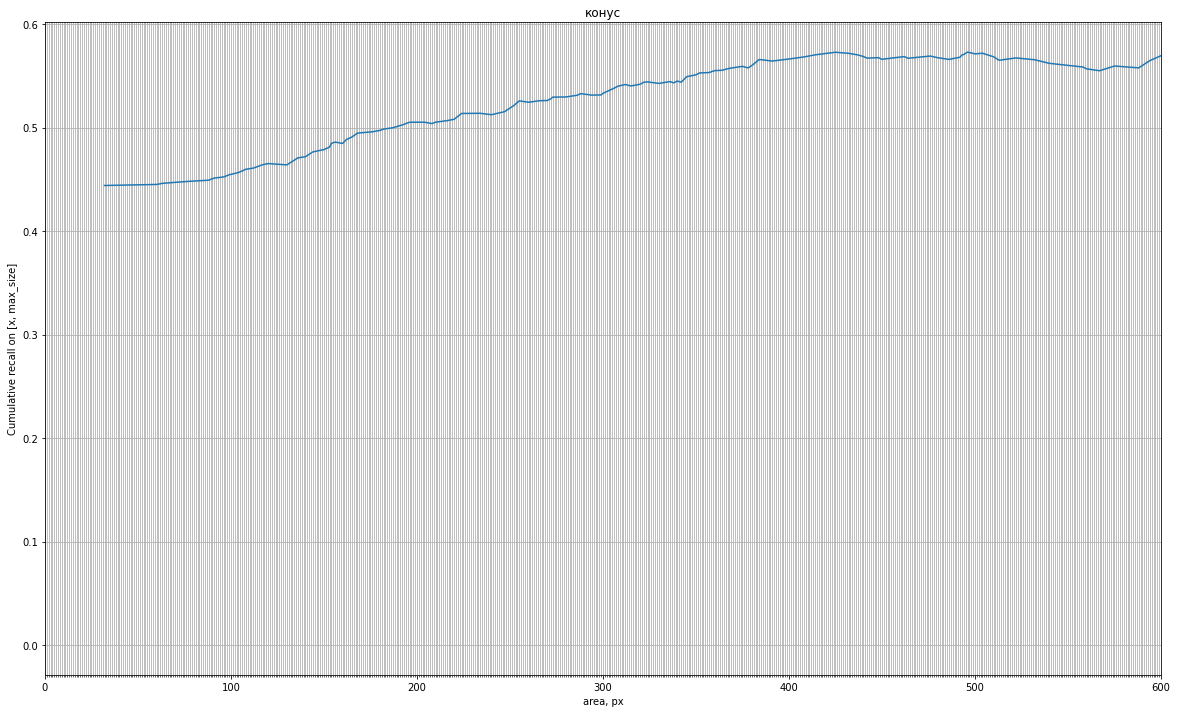

In [473]:
for class_name, class_table in area_table.items():
    plot_bar(class_table, 'area', class_name, lims=(0, 600), filename=f'recall_analysis/{class_name}_area.jpg', cmltv=True)

<ipython-input-464-682c46e8b11b>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_minor_locator(ml)


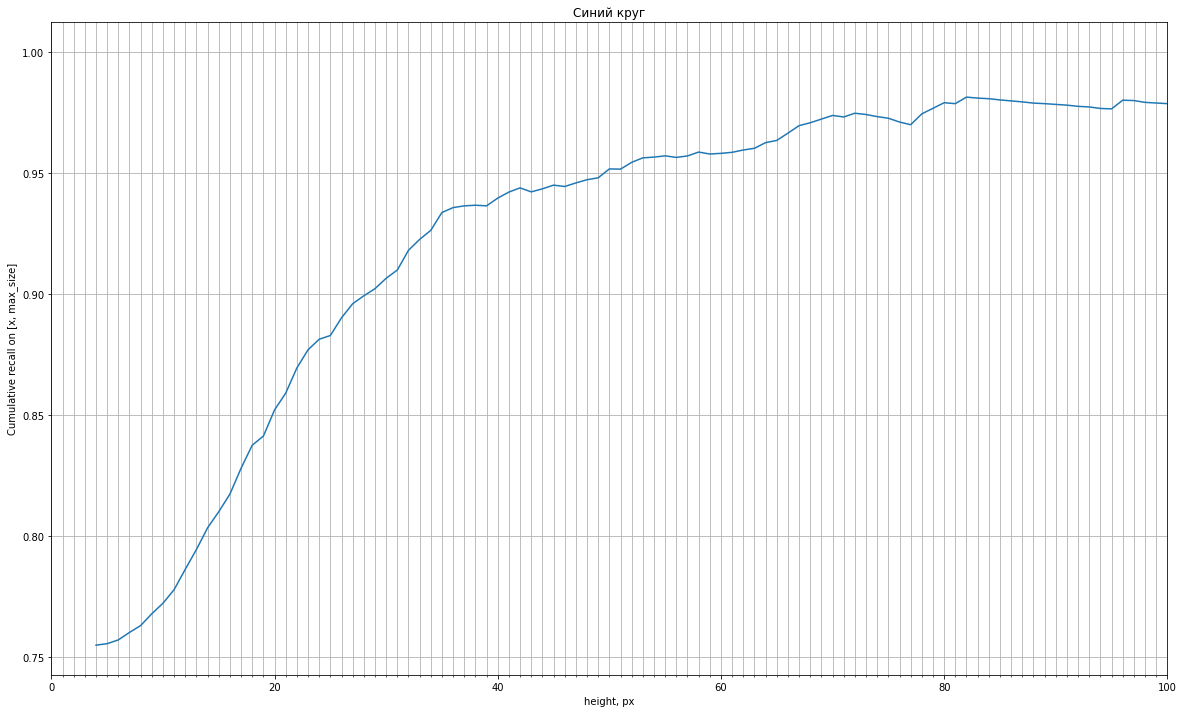

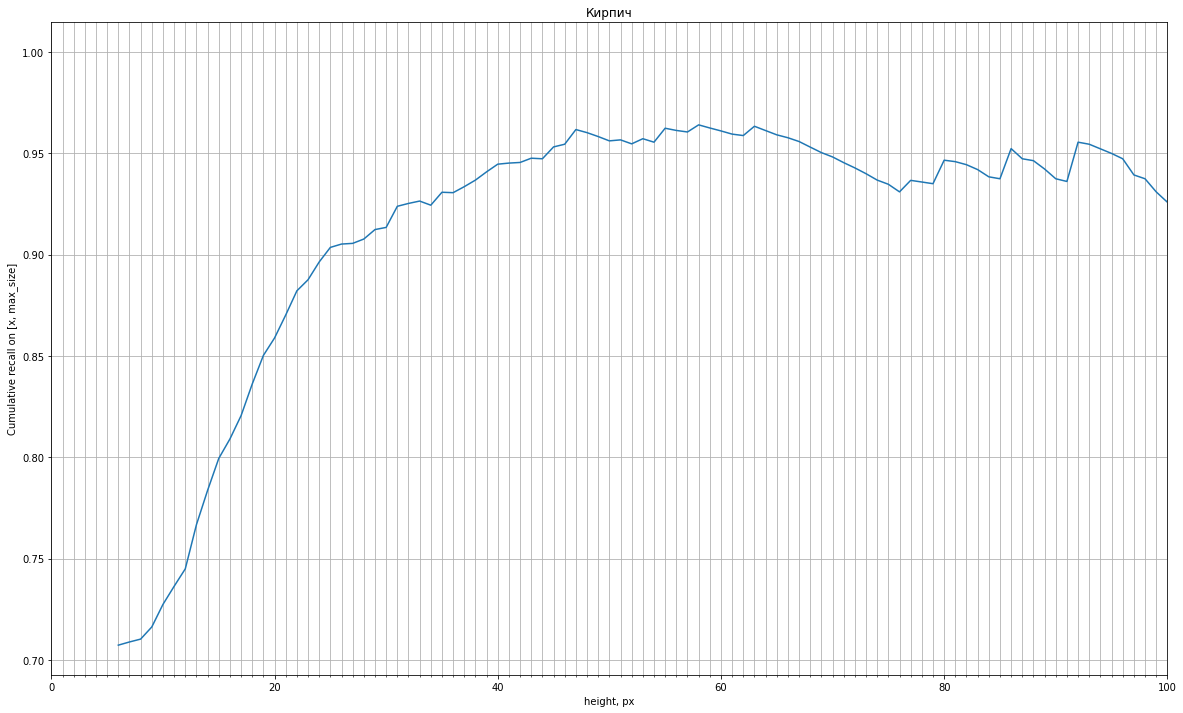

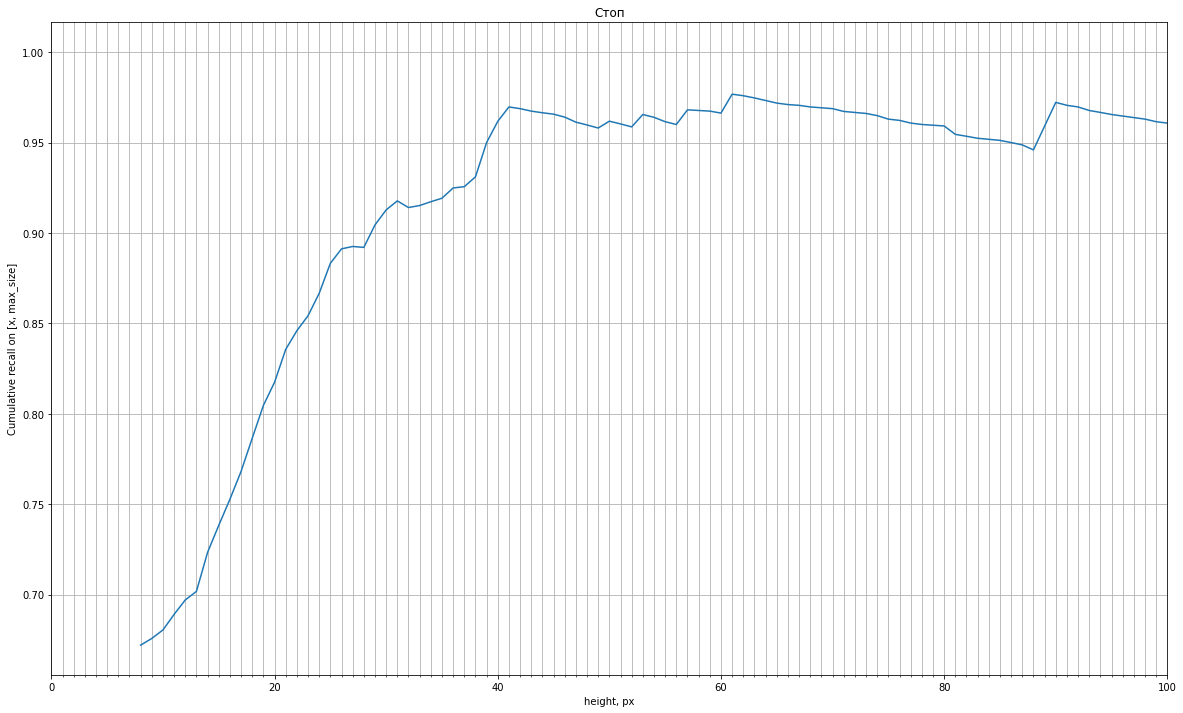

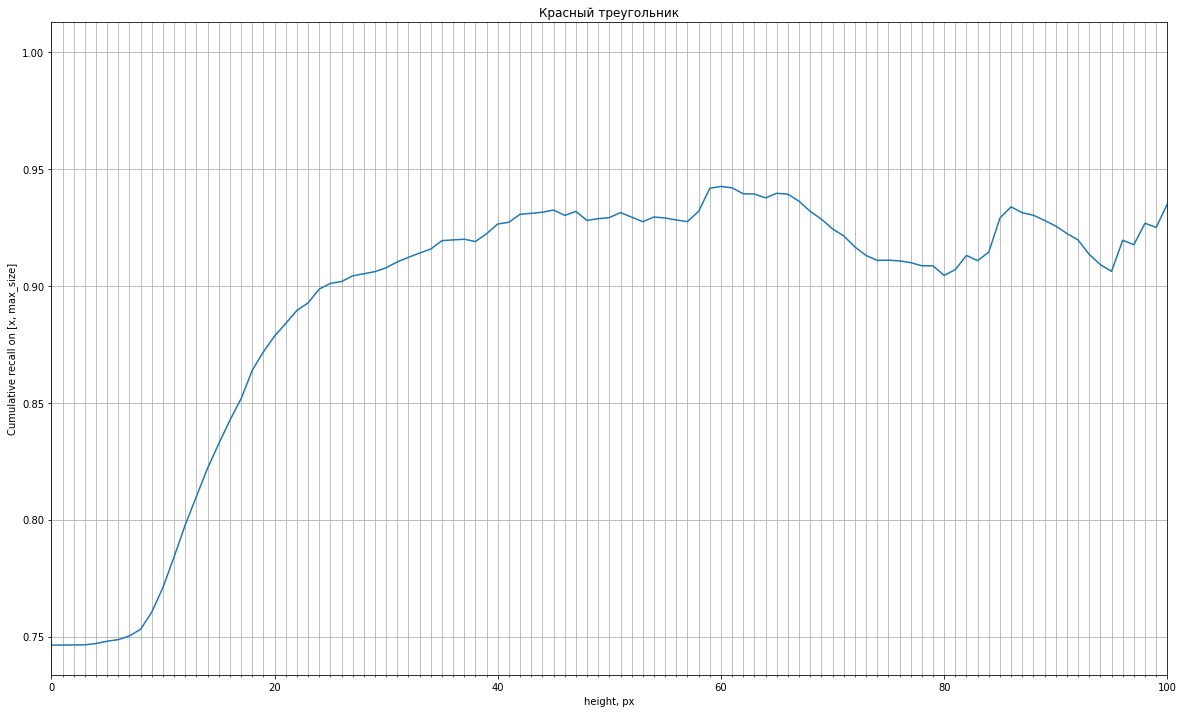

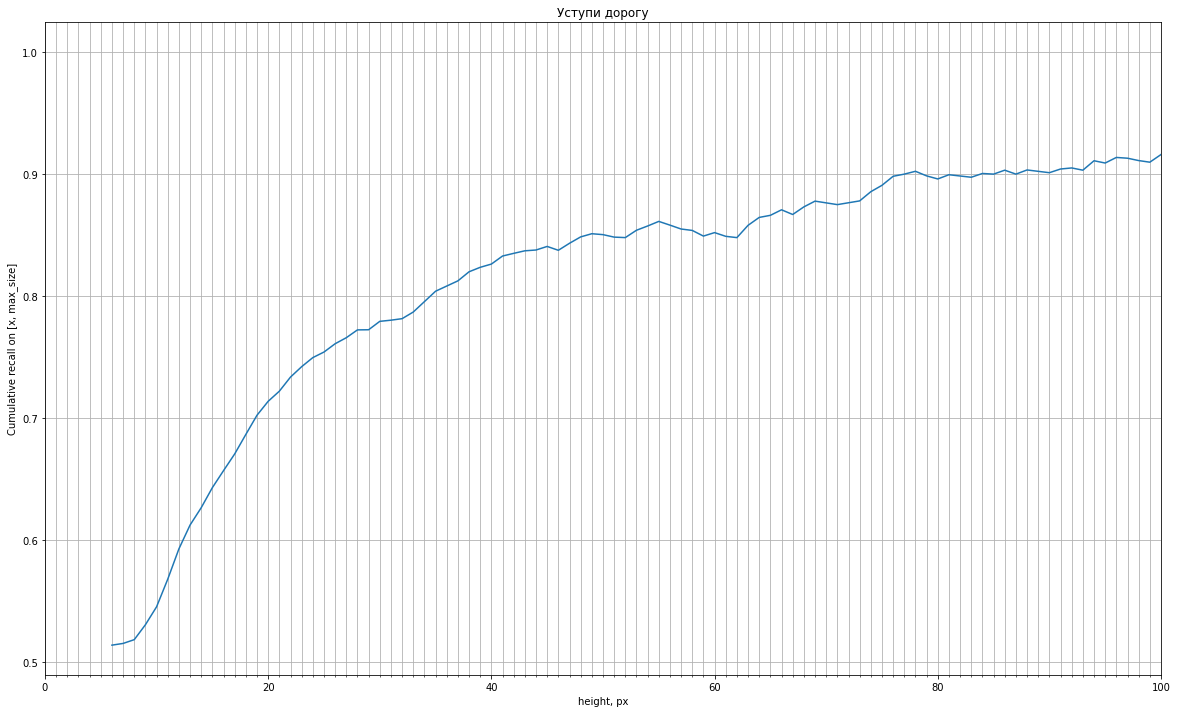

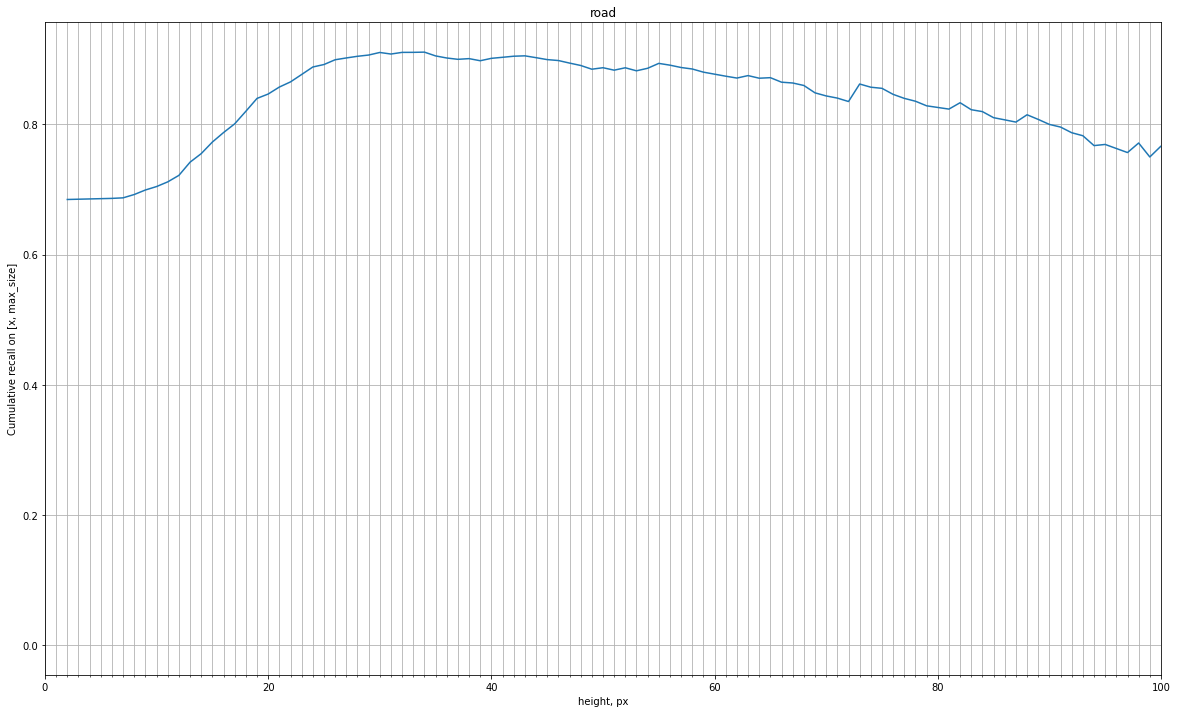

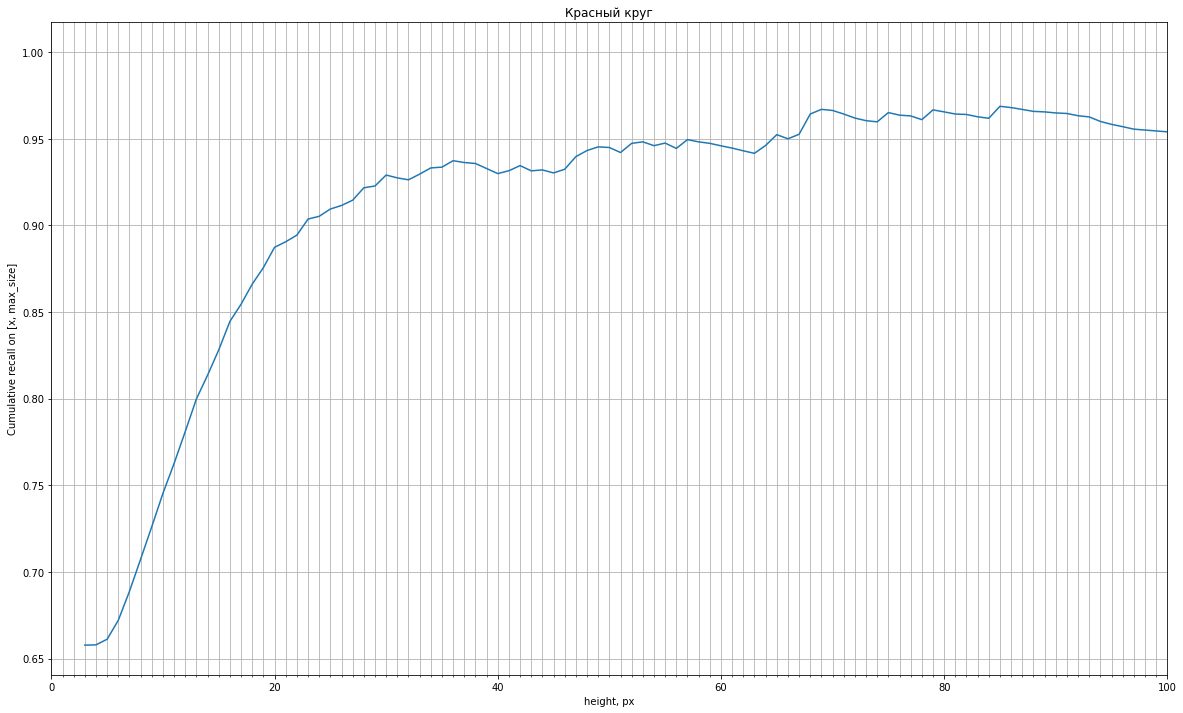

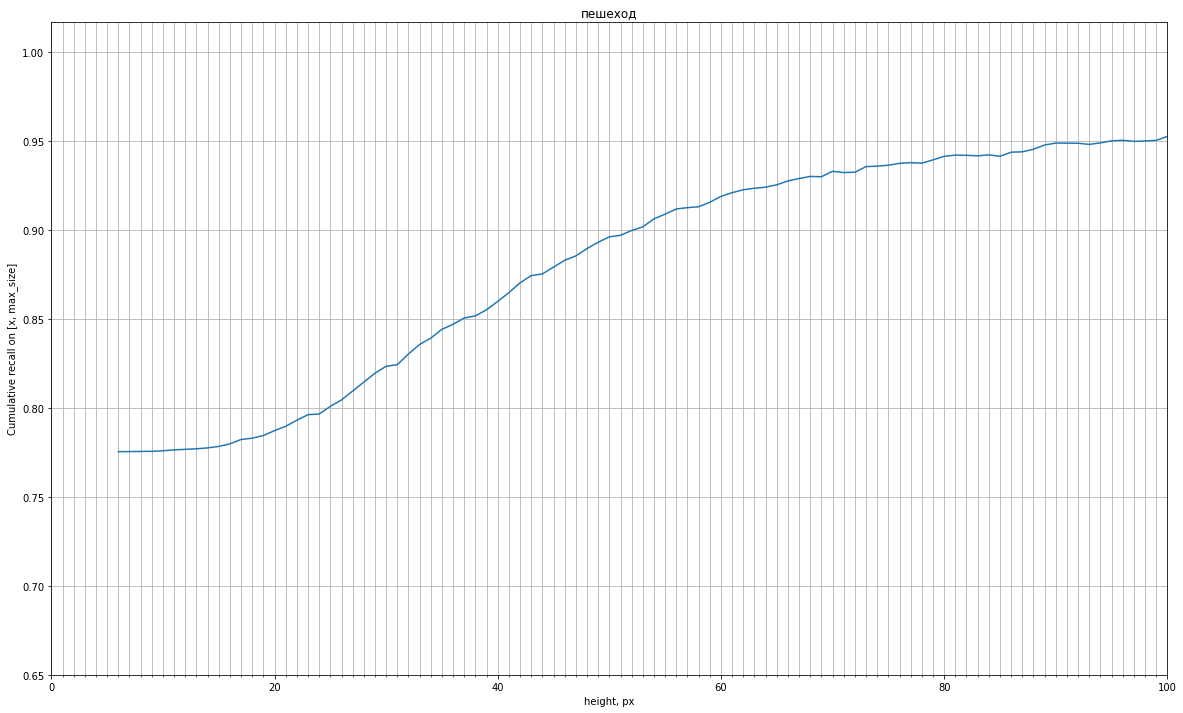

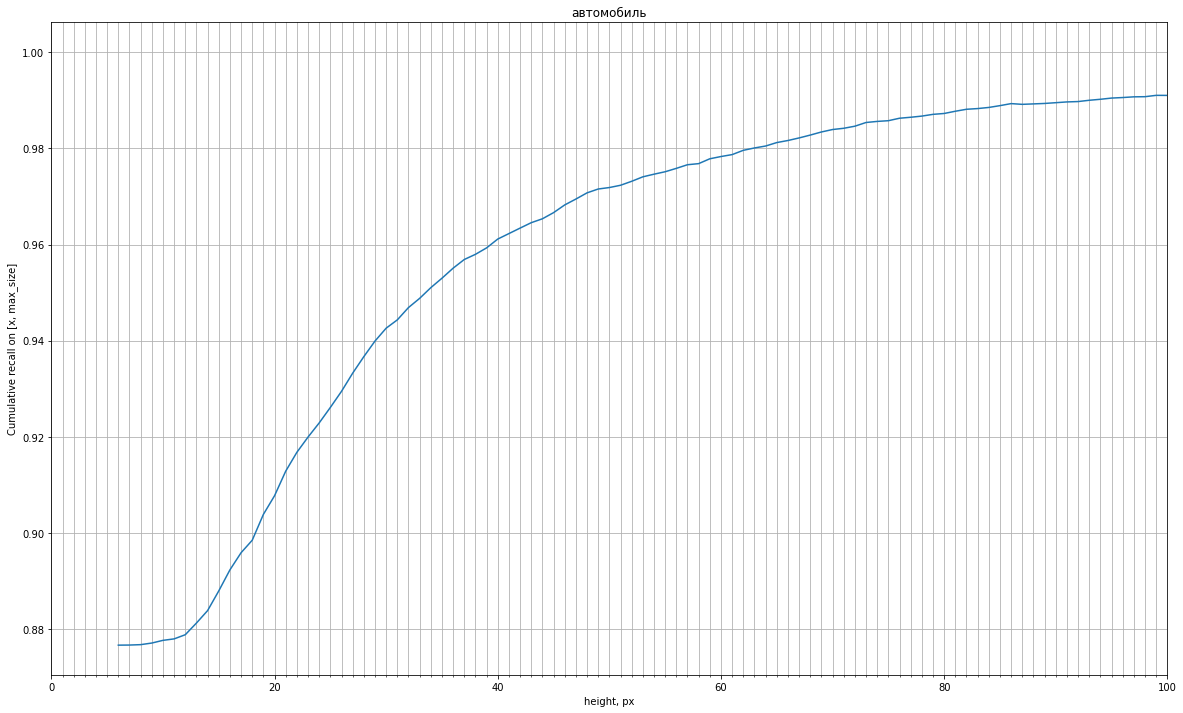

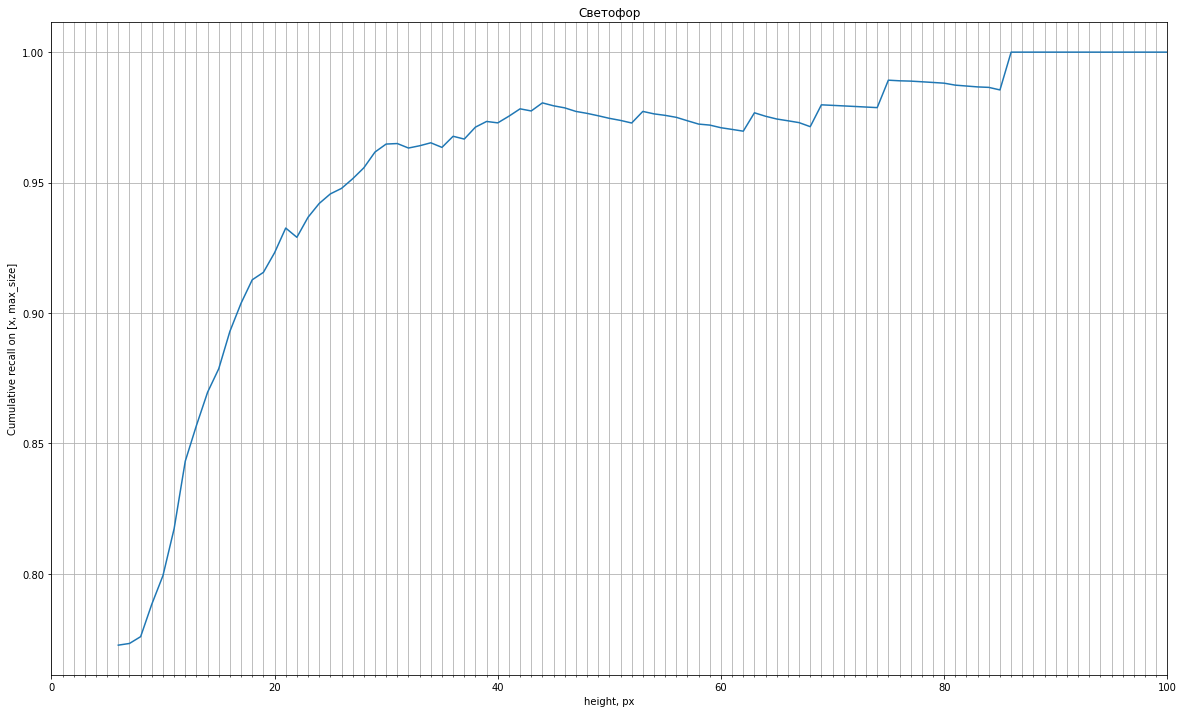

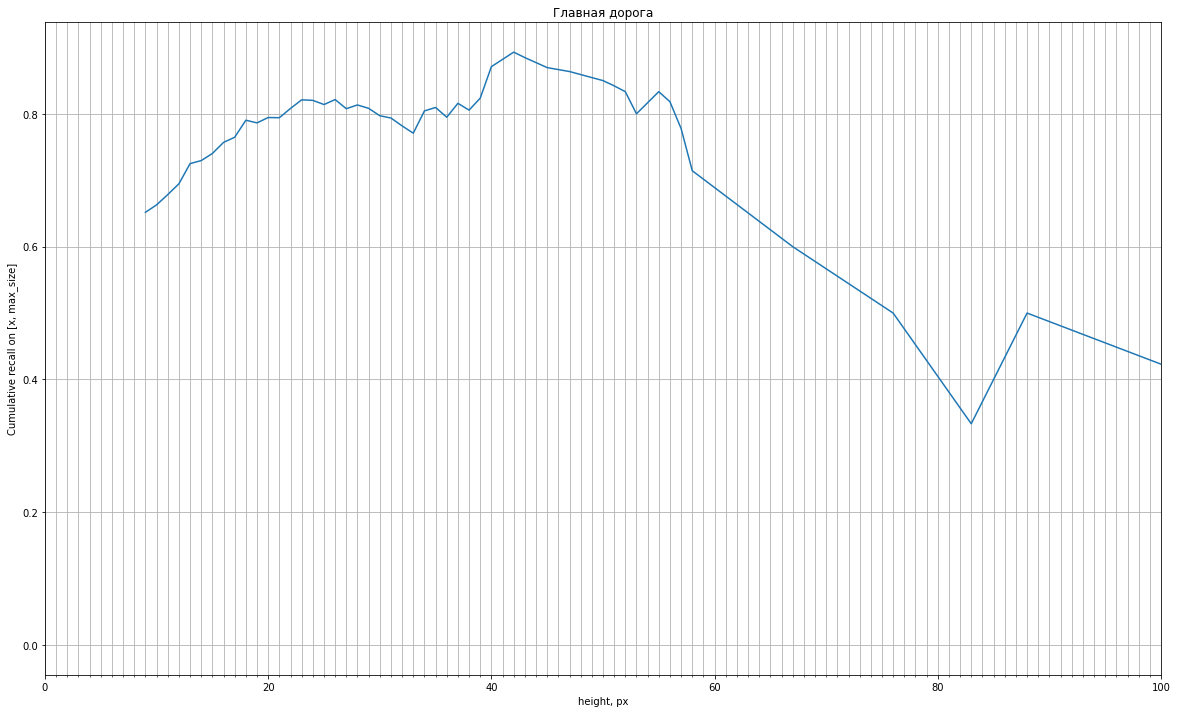

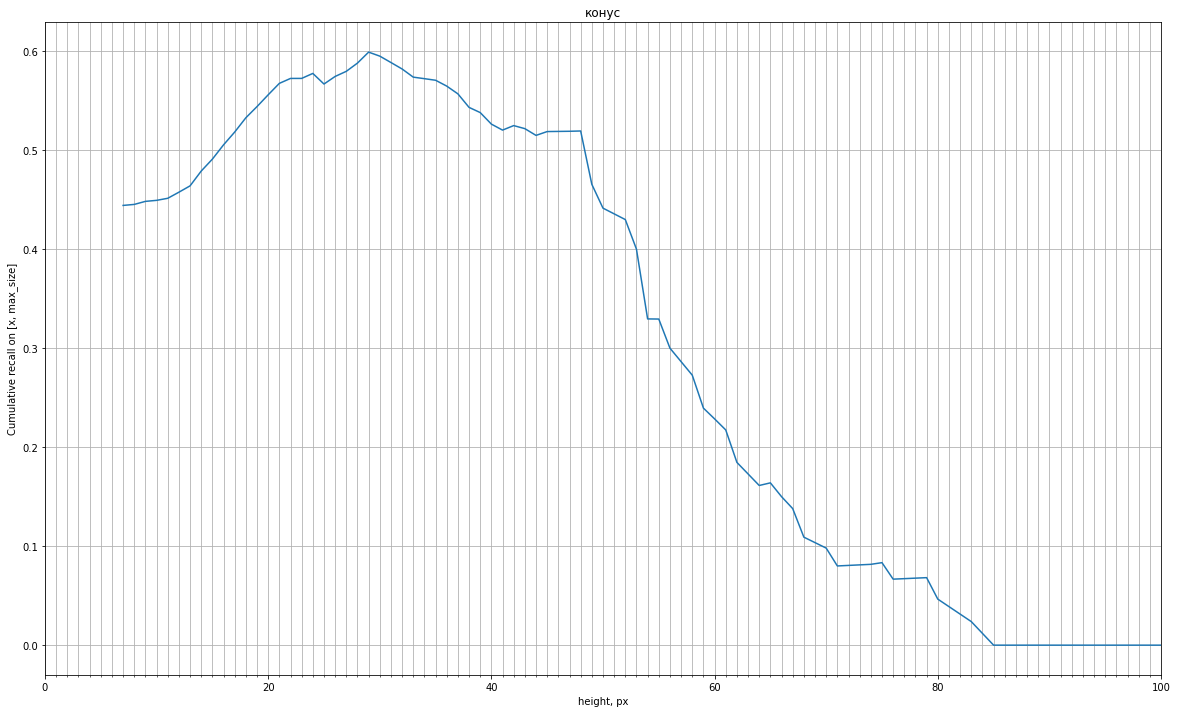

In [474]:
for class_name, class_table in height_table.items():
    plot_bar(class_table, 'height', class_name, filename=f'recall_analysis/{class_name}_height.jpg', cmltv=True)